In [1]:
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import scipy
import matplotlib
import tqdm
from scipy import integrate, fft, sparse
import pandas as pd
import seaborn as sns
import random
import anndata
import os
from sklearn.metrics import confusion_matrix
import loompy as lp

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import kneighbors_graph

import igraph as ig
import leidenalg as la

In [2]:
import sys
import importlib
sys.path.insert(0, '/home/tchari/monod/src/')

In [3]:
import monod
#importlib.reload(monod)
from monod import preprocess, extract_data, cme_toolbox, inference, analysis, mminference

In [4]:
import warnings
warnings.filterwarnings('ignore', category=PendingDeprecationWarning) 

## **Define Functions for Simulations**

In [5]:
class BurstModel():
    """
    This collection of convenience functions is placed in its own class mostly to avoid function name conflicts.
    """
    def __init__(self,seq_model='None',quad_method='fixed_quad',fixed_quad_T=10,quad_order=60,quad_vec_T=np.inf):
        self.seq_model = seq_model
        self.quad_method = quad_method
        self.fixed_quad_T = fixed_quad_T
        self.quad_order = quad_order
        self.quad_vec_T = quad_vec_T
        
    def burst_intfun(self, x, g, b, beta, gamma):
        if np.isclose(beta, gamma):
            c_1 = g[0]  
            c_2 = x * beta * g[1]
        else:
            f = beta / (beta - gamma)
            c_2 = g[1] * f
            c_1 = g[0] - c_2

        U = b * (np.exp(-beta * x) * c_1 + np.exp(-gamma * x) * c_2)
        return U / (1 - U)    
    
    def eval_model_pgf(self, p_, g):
        p = 10**p_
        b, beta, gamma = p

        
        fun = lambda x: self.burst_intfun(x, g, b, beta, gamma)
        if self.quad_method == "quad_vec":
            T = self.quad_vec_T * (1 / beta + 1 / gamma + 1)
            gf = scipy.integrate.quad_vec(fun, 0, T)[0]
        elif self.quad_method == "fixed_quad":
            T = self.fixed_quad_T * (1 / beta + 1 / gamma + 1)
            gf = scipy.integrate.fixed_quad(fun, 0, T, n=self.quad_order)[0]
        else:
            raise ValueError("Please use one of the specified quadrature methods.")
        return gf  # this is the log-generating function

    def get_Pss(self, p, limits, samp=None):
        u = []
        mx = np.copy(limits)
        mx[-1] = mx[-1] // 2 + 1
        for i in range(len(mx)):
            l = np.arange(mx[i])
            u_ = np.exp(-2j * np.pi * l / limits[i]) - 1
            u.append(u_)
        g = np.meshgrid(*[u_ for u_ in u], indexing="ij")
        for i in range(len(mx)):
            g[i] = g[i].flatten()
        g = np.asarray(g)[:, :, None]

        if self.seq_model == "Bernoulli":
            g *= np.asarray(samp)[:, None, None]
        elif self.seq_model == "Poisson":
            g = np.exp((np.power(10, samp))[:, None, None] * g) - 1

        gf = self.eval_model_pgf(p, g)
        gf = np.exp(gf)
        gf = gf.reshape(tuple(mx))
        
        
        Pss = scipy.fft.irfftn(gf, s=tuple(limits))
        
        
        Pss = np.abs(Pss) / np.sum(np.abs(Pss))
        
        Pss = Pss.squeeze()
        return Pss

In [6]:
def sample_from_p(num_data_points, Pss):
    mx = Pss.shape
    p_flat = Pss.flatten()
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')    # get grid of possible values
    x_choices = np.arange(np.prod(mx))                 # represent each grid point as a point in a 1D vector
    
    samples = np.random.choice(x_choices, size=num_data_points, replace=True, p=p_flat)
    d_N, d_M = X_N.flatten()[samples], X_M.flatten()[samples]    
    return d_N, d_M

## **Generate Counts**

In [443]:
def make_params(clus,n_genes,lens_sub,samples,glob_samp,num_marks,p=1.0,loc=1.5,single_param=None):
    #For each gene set params (clus x n_genes x 6), use gene lens from transcriptome file + use same gene names 
    params = np.zeros((clus,n_genes,6)) #b,k,beta,gamma,samp_n,samp_m, ALL LOG10
    for g in range(n_genes):
        g_len = lens_sub[g]
        params[:,g,0] = samples[g,0] + np.random.randn()*0.05 #int(np.random.uniform(8,12)) #b
        params[:,g,1] = 0 #np.random.uniform(0.1,0.5) #k
        params[:,g,2] = samples[g,1] + np.random.randn()*0.05 #np.random.normal(2,0.1)  #beta
        params[:,g,3] = samples[g,2] + np.random.randn()*0.05 #np.random.normal(0.8,0.1) #gamma

        params[:,g,4] = (glob_samp[0]) + np.log10(g_len) #C_nL
        params[:,g,5] = (glob_samp[1]) #lam_m



    #For each clus, select num_marks unique markers, add noise to b (log10b)
    all_choices = np.random.choice(range(n_genes), num_marks*clus, replace=False)
    if num_marks > 0:
        for c in range(clus):
            marks = all_choices[c*num_marks:(c+1)*num_marks]

            #UPDATE to change either b or beta&gamma
            for m in marks:
                if np.random.rand() < p:
                    params[c,m,0] += loc+np.random.randn()*0.1 #np.random.normal(loc=loc, scale = 0.1) #Only in burst size
                elif single_param == 'beta':
                    params[c,m,2] -= loc+np.random.randn()*0.1
                elif single_param == 'gamma':
                    params[c,m,3] -= loc+np.random.randn()*0.1
                else: 
                    params[c,m,2] -= loc+np.random.randn()*0.1 #np.random.normal(loc=loc, scale = 0.1)
                    params[c,m,3] -= loc+np.random.randn()*0.1 #np.random.normal(loc=loc, scale = 0.1)

    return params,all_choices


In [444]:
def make_all_params(clus,n_genes,lens_sub,samples,glob_samp,num_marks,p=1.0,loc=1.5,locb=1.5):
    #Change (1) all parameters at once or (2) b or beta/gamma with prob p
    params = np.zeros((clus,n_genes,6)) #b,k,beta,gamma,samp_n,samp_m, ALL LOG10
    for g in range(n_genes):
        g_len = lens_sub[g]
        params[:,g,0] = samples[g,0] + np.random.randn()*0.05 #int(np.random.uniform(8,12)) #b
        params[:,g,1] = 0 #np.random.uniform(0.1,0.5) #k
        params[:,g,2] = samples[g,1] + np.random.randn()*0.05 #np.random.normal(2,0.1)  #beta
        params[:,g,3] = samples[g,2] + np.random.randn()*0.05 #np.random.normal(0.8,0.1) #gamma

        params[:,g,4] = (glob_samp[0]) + np.log10(g_len) #C_nL
        params[:,g,5] = (glob_samp[1]) #lam_m



    #For each clus, select num_marks unique markers, add noise to b (log10b)
    all_choices = np.random.choice(range(n_genes), num_marks*clus, replace=False)
    if num_marks > 0:
        for c in range(clus):
            marks = all_choices[c*num_marks:(c+1)*num_marks]

            #UPDATE to change either b or beta&gamma
            for m in marks:
                if np.random.rand() < p:
                    if np.random.rand() < 0.5:
                        params[c,m,0] += locb+np.random.randn()*0.1 
                    else:
                        params[c,m,2] -= loc+np.random.randn()*0.1 #np.random.normal(loc=loc, scale = 0.1)
                        params[c,m,3] -= loc+np.random.randn()*0.1
                else:
                    params[c,m,0] += locb+np.random.randn()*0.1
                    params[c,m,2] += loc+np.random.randn()*0.1
                    params[c,m,3] += loc+np.random.randn()*0.1
                    

    return params,all_choices


In [445]:
def make_counts(clus,n_cells,n_genes,params):
    #Given parameters, sample counts from resulting probability distribution
    all_counts = np.zeros((clus*n_cells,n_genes,2))
    for c in range(clus):

        for g in range(n_genes):

            b = 10**params[c,g,0]
            k = 10**params[c,g,1]
            beta = 10**params[c,g,2]
            gamma = 10**params[c,g,3]

            lam_n = 10**params[c,g,4]
            lam_m = 10**params[c,g,5]

            p = np.log10(np.asarray([b,beta/k,gamma/k]))
            burst_model = BurstModel('Poisson')

            max_mean = b*np.asarray([lam_n/beta,lam_m/gamma]) #np.array(samp)*
            #max_std = np.sqrt(max_mean*(1+ b*np.asarray([1,beta/(beta+gamma)])))

            max_std = np.sqrt(max_mean*(1+np.asarray([lam_n*(1+b), lam_m*(1+b*beta/(beta+gamma))])))

            max_domain = np.maximum((max_mean + 4*max_std).astype(int),15)
            #max_domain = [int(i) for i in max_domain]

            Pss = burst_model.get_Pss(p,max_domain,np.log10([lam_n,lam_m]))

            #Get N and M count samples
            sampled = sample_from_p(n_cells, Pss)
            all_counts[c*n_cells:(c+1)*n_cells,g,0] = sampled[0]
            all_counts[c*n_cells:(c+1)*n_cells,g,1] = sampled[1]
            
    return all_counts

In [446]:
#No. of cells PER k cell 'type'
n_cells = 200
clus = 10

In [447]:
n_genes = 500
num_marks = 20 #7

In [448]:
#Technical sampling params
glob_samp = np.asarray([-7.157894736842105, -1.525])

In [449]:
transcriptome = pd.read_csv('/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3',delim_whitespace=True,header = None)
transcriptome.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,TNMD,14950,48,23,10,5,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0
1,DPM1,23689,98,38,25,17,10,6,5,5,...,0,0,0,0,0,0,0,0,0,0
2,SCYL3,44637,132,51,20,13,9,7,6,4,...,0,0,0,0,0,0,0,0,0,0
3,TSPAN6,12884,43,18,13,8,3,2,2,1,...,0,0,0,0,0,0,0,0,0,0
4,FGR,23122,41,18,8,4,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [450]:
#Initialize params and correlations, per gene
np.random.seed(40)

mean = np.asarray([1.2, 0.2, 0.5, 5]) #b, beta, gamma, L .... b=1 before
std = np.asarray([0.6, 0.3, 0.5, 0.5]) # for b, was 0.6
var = std[:, None] * std[None, :]
rho = [0.8, 0.8, 0.8, -0.1, 0, 0] #Incorporate corrs b/w params
pairs = [[1, 2], [0, 1], [0, 2], [0, 3], [1, 3], [2, 3]]
for k, p in enumerate(pairs):
    var[p[0], p[1]] *= rho[k]
    var[p[1], p[0]] *= rho[k]
samples = np.random.multivariate_normal(mean, var, n_genes)


In [451]:
samples.shape

(500, 4)

In [452]:
#Select genes from real transcriptome

gene_names = np.array(transcriptome[0])

names_sub = gene_names[0:n_genes]


transcriptome_sub = transcriptome[0:n_genes]
lens_sub = 10**samples[:,3]
transcriptome_sub[1] = [int(i) for i in lens_sub]
transcriptome_sub.head()

#make new transcriptome in same style
transcriptome_sub.to_csv('/home/tchari/perturbCME/notebooks/mmSim_edgecase_genome_polyA_cum_3',sep=' ', index=False)



/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [453]:
all_params = []
all_marks = []


out = make_params(clus,n_genes,lens_sub,samples,glob_samp,num_marks,p=0.5,loc=1.5,single_param='beta')
all_params += [out[0]]
all_marks += [out[1]]

out = make_all_params(clus,n_genes,lens_sub,samples,glob_samp,num_marks,p=0.1,loc=1.5,locb=1.5)

all_params += [out[0]]
all_marks += [out[1]]

In [498]:
len(all_counts)

2

In [454]:
all_counts = []
for params in all_params:
    all_counts += [make_counts(clus,n_cells,n_genes,params)]

In [455]:
all_assigns = []
for c in range(clus):
    all_assigns += [c]*n_cells

In [456]:
all_counts[0].shape

(2000, 500, 2)

In [628]:
#To test other sims 
out = make_all_params(clus,n_genes,lens_sub,samples,glob_samp,num_marks,p=0.0,loc=1.0,locb=3.0)
all_params[1] = out[0]
all_marks[1] = out[1]

all_counts[1] = make_counts(clus,n_cells,n_genes,all_params[1])

**Make sure sims look ok**

<AxesSubplot:ylabel='Count'>

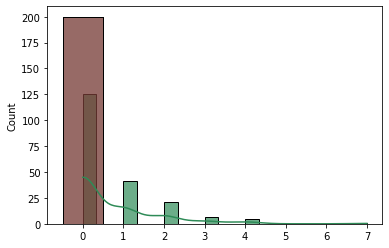

In [629]:
sns.histplot(x=all_counts[1][0:200,all_marks[1][10],0],alpha=0.7,kde=True,color='seagreen')
sns.histplot(x=all_counts[1][200:400,all_marks[1][10],0],alpha=0.6,kde=True,color='salmon')
sns.histplot(x=all_counts[1][400:600,all_marks[1][10],0],alpha=0.4,kde=True,color='black')

Text(0, 0.5, 'log beta (beta)')

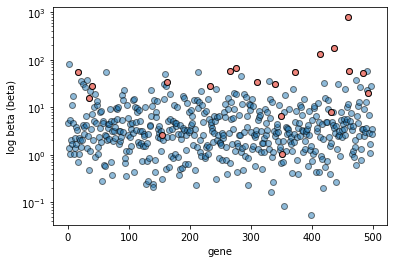

In [571]:
test_out = all_params[-1]
test_marks = all_marks[-1][0:num_marks]

plt.scatter(range(len(test_out[0,:,0])), 10**test_out[0,:,3],alpha=0.5,edgecolor='black')
plt.scatter(np.array(range(len(test_out[0,:,0])))[test_marks], 10**test_out[0,:,3][test_marks],color='salmon',alpha=0.9,edgecolor='black')
plt.yscale('log')
plt.xlabel('gene')
plt.ylabel('log beta (beta)')

Text(0, 0.5, 'log burst size (b)')

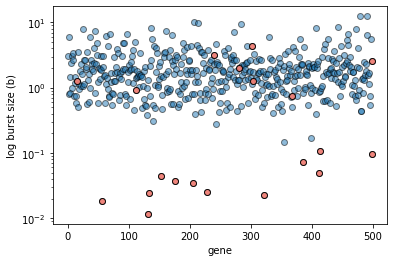

In [572]:
test_out = all_params[0]
test_marks = all_marks[0][0:num_marks]

plt.scatter(range(len(test_out[0,:,2])), 10**test_out[0,:,2],alpha=0.5,edgecolor='black')
plt.scatter(np.array(range(len(test_out[0,:,2])))[test_marks], 10**test_out[0,:,2][test_marks],color='salmon',alpha=0.9,edgecolor='black')
plt.yscale('log')
plt.xlabel('gene')
plt.ylabel('log burst size (b)')

[[1.         0.43436067]
 [0.43436067 1.        ]]


Text(0, 0.5, 'param mean U')

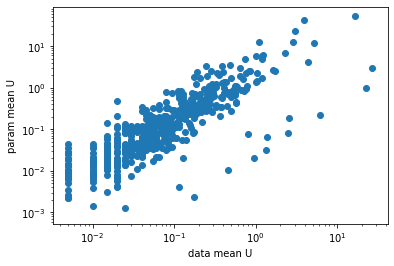

In [573]:
#Check relationship between means and means from params
k1 = all_counts[0][0:200,:,:]
k1.shape

sim_mean = test_out[0,:,0]+test_out[0,:,4]-test_out[0,:,1]
plt.scatter(np.mean(k1[:,:,0],axis=0),10**sim_mean )
print(np.corrcoef(np.mean(k1[:,:,0],axis=0),10**(sim_mean )))
plt.xscale("log")
plt.yscale("log")
plt.xlabel('data mean U')
plt.ylabel('param mean U')

In [574]:
test_cluster = all_counts[-1]

In [575]:
concat_types = np.concatenate((np.mean(test_cluster[0:200,:,:],axis=0),np.mean(test_cluster[200:400,:,:],axis=0),
          np.mean(test_cluster[400:600,:,:],axis=0)),axis=1)


[Text(1, 0.5, '170'),
 Text(1, 1.5, '154'),
 Text(1, 2.5, '461'),
 Text(1, 3.5, '437'),
 Text(1, 4.5, '40'),
 Text(1, 5.5, '351'),
 Text(1, 6.5, '339'),
 Text(1, 7.5, '350'),
 Text(1, 8.5, '414'),
 Text(1, 9.5, '202'),
 Text(1, 10.5, '116'),
 Text(1, 11.5, '190'),
 Text(1, 12.5, '310'),
 Text(1, 13.5, '483'),
 Text(1, 14.5, '265'),
 Text(1, 15.5, '162'),
 Text(1, 16.5, '275'),
 Text(1, 17.5, '49'),
 Text(1, 18.5, '340'),
 Text(1, 19.5, '243'),
 Text(1, 20.5, '266'),
 Text(1, 21.5, '113'),
 Text(1, 22.5, '32'),
 Text(1, 23.5, '168'),
 Text(1, 24.5, '331'),
 Text(1, 25.5, '41'),
 Text(1, 26.5, '141'),
 Text(1, 27.5, '195'),
 Text(1, 28.5, '450'),
 Text(1, 29.5, '203'),
 Text(1, 30.5, '217'),
 Text(1, 31.5, '101'),
 Text(1, 32.5, '365'),
 Text(1, 33.5, '455'),
 Text(1, 34.5, '92'),
 Text(1, 35.5, '406'),
 Text(1, 36.5, '1'),
 Text(1, 37.5, '47'),
 Text(1, 38.5, '234'),
 Text(1, 39.5, '244'),
 Text(1, 40.5, '288'),
 Text(1, 41.5, '14'),
 Text(1, 42.5, '478'),
 Text(1, 43.5, '148'),
 Text(1

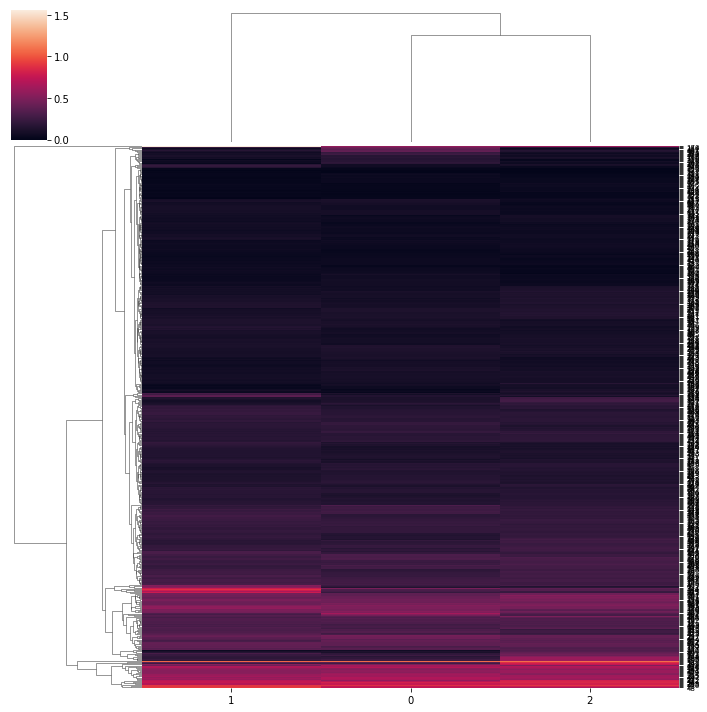

In [576]:
#How separated are clusters by 'DE genes,', Shows N and M
g = sns.clustermap(np.log1p(concat_types[:,[1,3,5]]),yticklabels=True)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 7)



[Text(1, 0.5, '29'),
 Text(1, 1.5, '276'),
 Text(1, 2.5, '138'),
 Text(1, 3.5, '369'),
 Text(1, 4.5, '444'),
 Text(1, 5.5, '324'),
 Text(1, 6.5, '417'),
 Text(1, 7.5, '162'),
 Text(1, 8.5, '233'),
 Text(1, 9.5, '437'),
 Text(1, 10.5, '339'),
 Text(1, 11.5, '483'),
 Text(1, 12.5, '163'),
 Text(1, 13.5, '461'),
 Text(1, 14.5, '130'),
 Text(1, 15.5, '103'),
 Text(1, 16.5, '406'),
 Text(1, 17.5, '177'),
 Text(1, 18.5, '333'),
 Text(1, 19.5, '74'),
 Text(1, 20.5, '180'),
 Text(1, 21.5, '6'),
 Text(1, 22.5, '53'),
 Text(1, 23.5, '284'),
 Text(1, 24.5, '332'),
 Text(1, 25.5, '194'),
 Text(1, 26.5, '14'),
 Text(1, 27.5, '51'),
 Text(1, 28.5, '217'),
 Text(1, 29.5, '236'),
 Text(1, 30.5, '228'),
 Text(1, 31.5, '240'),
 Text(1, 32.5, '317'),
 Text(1, 33.5, '371'),
 Text(1, 34.5, '446'),
 Text(1, 35.5, '354'),
 Text(1, 36.5, '394'),
 Text(1, 37.5, '331'),
 Text(1, 38.5, '160'),
 Text(1, 39.5, '320'),
 Text(1, 40.5, '244'),
 Text(1, 41.5, '141'),
 Text(1, 42.5, '289'),
 Text(1, 43.5, '73'),
 Text(

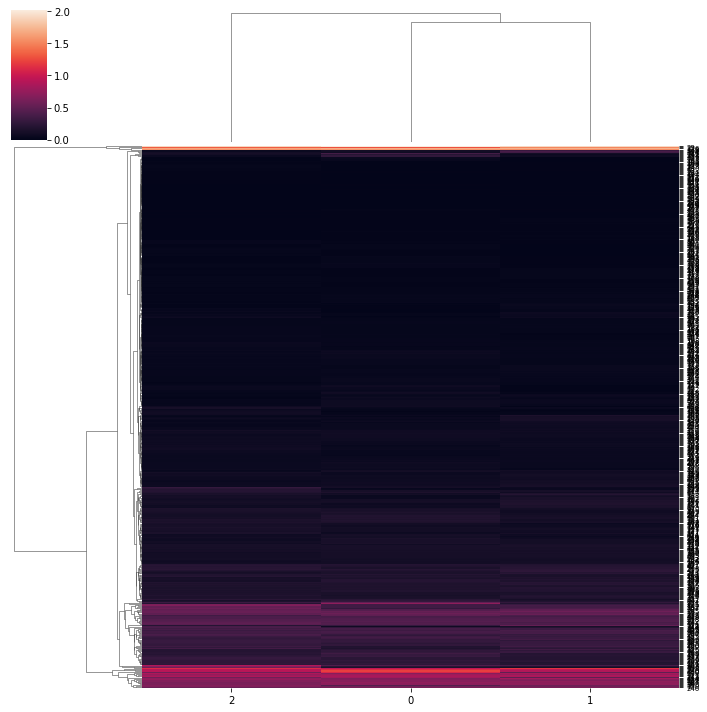

In [577]:
#How separated are clusters by 'DE genes,', Shows N and M
g = sns.clustermap(np.log1p(concat_types[:,[0,2,4]]),yticklabels=True)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 7)



Text(0, 0.5, 'Mature counts')

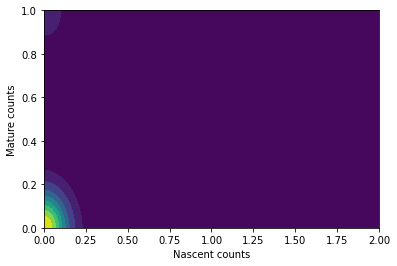

In [578]:
plt.figure()
test_gene = k1[:,50,:]
sns.kdeplot(x=test_gene[:,0], y=test_gene[:,1], cmap="viridis", shade=True, thresh=0)
plt.xlim(np.min(test_gene[:,0]),np.max(test_gene[:,0]))
plt.ylim(np.min(test_gene[:,1]),np.max(test_gene[:,1]))
plt.xlabel('Nascent counts')
plt.ylabel('Mature counts')


In [579]:
np.max(k1)

128.0

**Save count matrices for Monod**

In [466]:
!mkdir ~/counts/mixMod_edgecase_sims
!mkdir ~/counts/mixMod_edgecase_sims/loom/

mkdir: cannot create directory ‘/home/tchari/counts/mixMod_edgecase_sims’: File exists
mkdir: cannot create directory ‘/home/tchari/counts/mixMod_edgecase_sims/loom/’: File exists


In [630]:
out_names = ['beta80_sim_k10','all90_sim_k10'] 

In [631]:
#And save clus labels for cells + barcodes for each cell in metadata + loom
out_path = '/home/tchari/counts/mixMod_edgecase_sims/loom/'
geneNames = names_sub
for ind in range(len(out_names)):
    U = all_counts[ind][:,:,0]
    S = all_counts[ind][:,:,1]
    
    bars = [str(i) for i in range(n_cells*clus)]

    fname = out_path+out_names[ind]+'.loom'

    print('Making Loom')
    #Make loom of U/S
    retAdata = anndata.AnnData(
                X=sparse.csr_matrix(S),
                layers={
                    'spliced': sparse.csr_matrix(S),
                    'unspliced': sparse.csr_matrix(U),
                },
                obs=pd.DataFrame({'barcode': np.array(bars)},index=np.array(bars)),
                var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
            )

    retAdata.write_loom(fname)
    print(fname)


Making Loom
/home/tchari/counts/mixMod_edgecase_sims/loom/beta80_sim_k10.loom
Making Loom


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


/home/tchari/counts/mixMod_edgecase_sims/loom/all90_sim_k10.loom


In [632]:
#----- EXTRA CONTROL: Make loom with just one cluster, for comparing to Monod fits -----
out_path = '/home/tchari/counts/mixMod_edgecase_sims/loom/'
U = all_counts[0][0:n_cells,:,0]
S = all_counts[0][0:n_cells,:,1]
geneNames = names_sub
bs = [str(i) for i in range(n_cells)]

fname = out_path+'oneClus_beta80_sim_k10.loom'

print('Making Loom')
#Make loom of U/S
retAdata = anndata.AnnData(
			X=sparse.csr_matrix(S),
			layers={
				'spliced': sparse.csr_matrix(S),
				'unspliced': sparse.csr_matrix(U),
			},
			obs=pd.DataFrame({'barcode': np.array(bs)},index=np.array(bs)),
			var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
		)

retAdata.write_loom(fname)
print(fname)

Making Loom
/home/tchari/counts/mixMod_edgecase_sims/loom/oneClus_beta80_sim_k10.loom


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [633]:
#----- EXTRA CONTROL: Make loom with just one cluster, for comparing to Monod fits, for b,beta and gamma sim -----
out_path = '/home/tchari/counts/mixMod_edgecase_sims/loom/'
U = all_counts[-1][0:n_cells,:,0]
S = all_counts[-1][0:n_cells,:,1]
geneNames = names_sub
bs = [str(i) for i in range(n_cells)]

fname = out_path+'oneClus_all90_sim_k10.loom'

print('Making Loom')
#Make loom of U/S
retAdata = anndata.AnnData(
			X=sparse.csr_matrix(S),
			layers={
				'spliced': sparse.csr_matrix(S),
				'unspliced': sparse.csr_matrix(U),
			},
			obs=pd.DataFrame({'barcode': np.array(bs)},index=np.array(bs)),
			var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
		)

retAdata.write_loom(fname)
print(fname)

Making Loom
/home/tchari/counts/mixMod_edgecase_sims/loom/oneClus_all90_sim_k10.loom


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


## **Run Inference**

In [634]:
rep_data = list(np.repeat(out_names,4))+['oneClus_beta80_sim_k10']+['oneClus_all90_sim_k10']
ks = [1,5,10,15]*len(out_names)+[1,1]

dataset_meta = rep_data #['burst_mark_sim','oneClus_burst_mark_sim']
print('dataset_meta: ', dataset_meta)
print()


cluster_names = []

d_names = []
for i in range(len(ks)):
    d_names += [rep_data[i]+'_k'+str(ks[i])]
    
dataset_names = d_names  #To save
print('dataset_names: ', dataset_names)
print('len(dataset_names): ',len(dataset_names))
print()

raw_data_locations = rep_data 
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/mmSim_edgecase_genome_polyA_cum_3' #'gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/tchari/counts/mixMod_edgecase_sims/loom/'+x+'.loom' for x in raw_data_locations] 
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

dataset_meta:  ['beta80_sim_k10', 'beta80_sim_k10', 'beta80_sim_k10', 'beta80_sim_k10', 'all90_sim_k10', 'all90_sim_k10', 'all90_sim_k10', 'all90_sim_k10', 'oneClus_beta80_sim_k10', 'oneClus_all90_sim_k10']

dataset_names:  ['beta80_sim_k10_k1', 'beta80_sim_k10_k5', 'beta80_sim_k10_k10', 'beta80_sim_k10_k15', 'all90_sim_k10_k1', 'all90_sim_k10_k5', 'all90_sim_k10_k10', 'all90_sim_k10_k15', 'oneClus_beta80_sim_k10_k1', 'oneClus_all90_sim_k10_k1']
len(dataset_names):  10

loom_filepaths:  ['/home/tchari/counts/mixMod_edgecase_sims/loom/beta80_sim_k10.loom', '/home/tchari/counts/mixMod_edgecase_sims/loom/beta80_sim_k10.loom', '/home/tchari/counts/mixMod_edgecase_sims/loom/beta80_sim_k10.loom', '/home/tchari/counts/mixMod_edgecase_sims/loom/beta80_sim_k10.loom', '/home/tchari/counts/mixMod_edgecase_sims/loom/all90_sim_k10.loom', '/home/tchari/counts/mixMod_edgecase_sims/loom/all90_sim_k10.loom', '/home/tchari/counts/mixMod_edgecase_sims/loom/all90_sim_k10.loom', '/home/tchari/counts/mixMod

In [635]:
print(n_datasets)

10


Dataset beta80_sim_k10. 
	2000 barcodes in loom, 38 pass filter. 2000 in annotations; of these, 2000 in loom and 38 in filtered loom.
	Keep All: 2000 cells in annotations. 2000 in loom. 2000 pass filter.
Dataset beta80_sim_k10. 
	2000 barcodes in loom, 38 pass filter. 2000 in annotations; of these, 2000 in loom and 38 in filtered loom.
	Keep All: 2000 cells in annotations. 2000 in loom. 2000 pass filter.
Dataset beta80_sim_k10. 
	2000 barcodes in loom, 38 pass filter. 2000 in annotations; of these, 2000 in loom and 38 in filtered loom.
	Keep All: 2000 cells in annotations. 2000 in loom. 2000 pass filter.
Dataset beta80_sim_k10. 
	2000 barcodes in loom, 38 pass filter. 2000 in annotations; of these, 2000 in loom and 38 in filtered loom.
	Keep All: 2000 cells in annotations. 2000 in loom. 2000 pass filter.
Dataset all90_sim_k10. 
	2000 barcodes in loom, 459 pass filter. 2000 in annotations; of these, 2000 in loom and 459 in filtered loom.
	Keep All: 2000 cells in annotations. 2000 in loo

/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


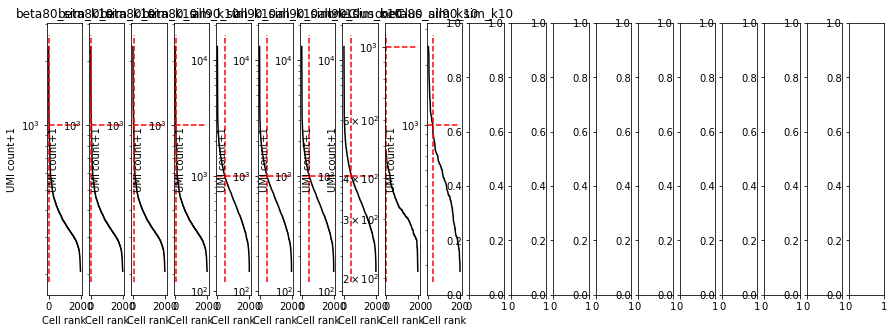

In [636]:
#Not filtering cells for now
cf = []
thr_lb = [1e3]*len(dataset_meta)*2

fig1,ax1 = plt.subplots(1,len(dataset_meta)*2,figsize=(15,5))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[k]
    dataset_name = raw_data_locations[k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = len(bcs)
        annot_bcs_in_loom = len(bcs)
        annot_bcs_in_filt_loom = cf_.sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        
        #if k==0:
        #for subcluster in subcluster_names:
        subcluster = 'Keep All'
        annot_bcs = bcs
        #cf.append(np.isin(bcs,annot_bcs) & cf_)
        cf.append(np.isin(bcs,annot_bcs))
        print(f'\t{subcluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')



    ax1[k].set_title(dataset_name)
    
!mkdir ./figs    
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_burst_mark_sim_edgecase_forMM.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)

In [637]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

In [638]:
#Define bounds, from 20220930_normanfit_monod.ipynb
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-7.157894736842105, -1.525] #-7.5, -2
samp_ub = [-7.157894736842105, -1.525] #-5.5, 0
# gridsize = [5,6]
gridsize = [1,1]


INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1 already exists.
INFO:root:Dataset: beta80_sim_k10_k1
INFO:root:2000 cells detected.
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:199 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k1 already exists.
INFO:root:Dataset: beta80_sim_k10_k5
INFO:root:2000 cells detected.
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:199 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k5 already exists.
INFO:root:Dataset: beta80_sim_k10_k10
INFO:root:2000 cells detected.
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:199 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1

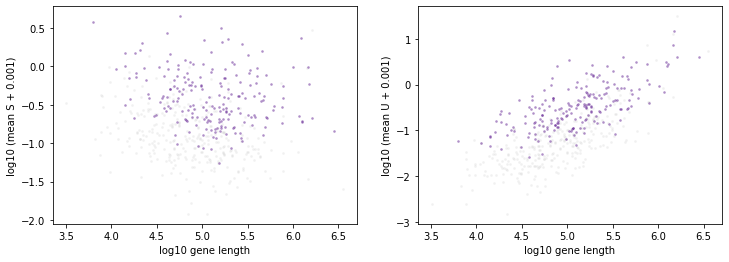

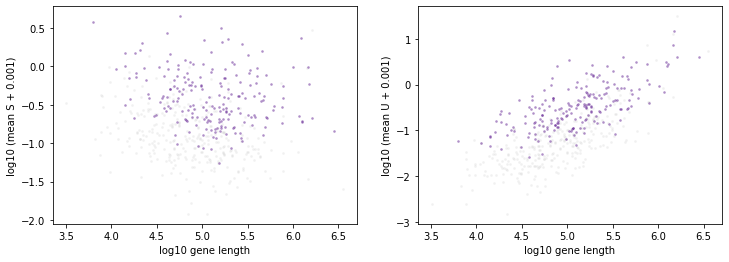

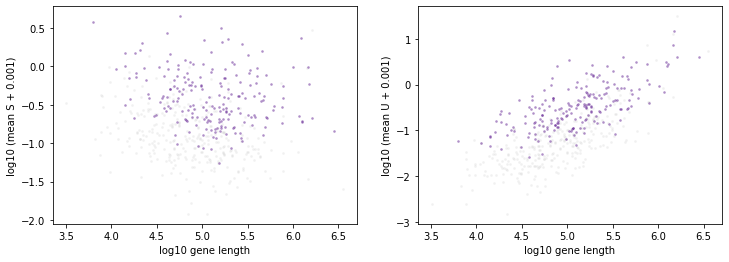

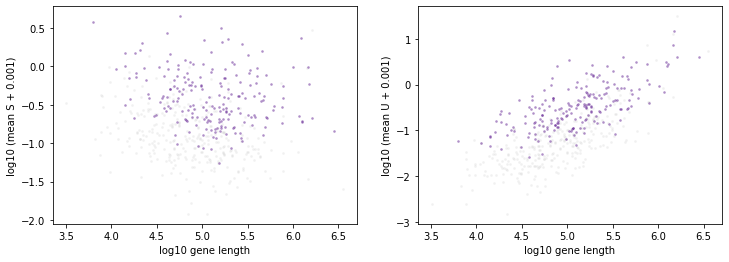

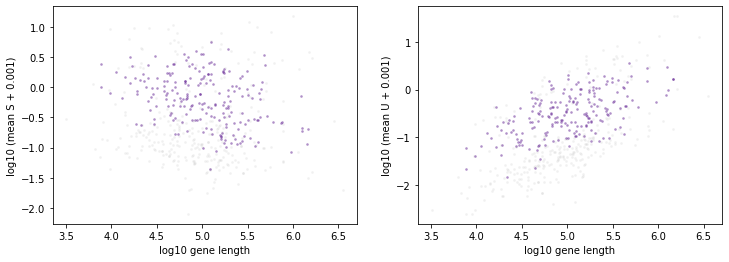

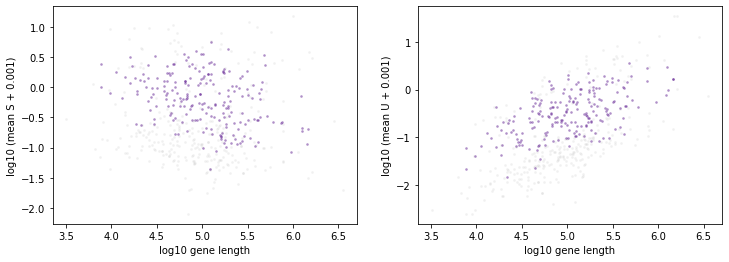

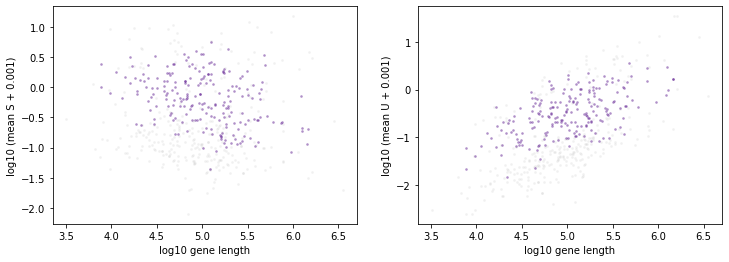

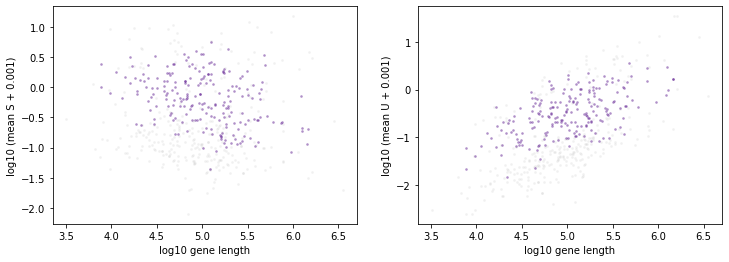

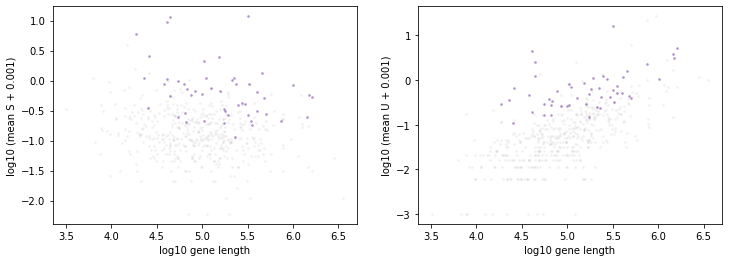

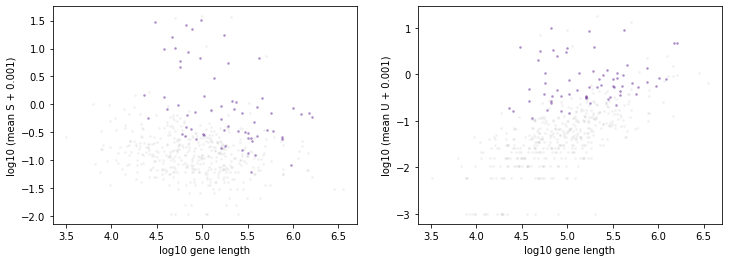

In [639]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='simTests_edgecase_MM',batch_id=1,\
                                             datestring='230505', n_genes=n_genes,exp_filter_threshold=None,cf=cf) #230411

In [640]:
dir_string = './fits/gg_230505_025_simTests_edgecase_MM_1'
dataset_strings = [ dir_string+'/'+item for item in dataset_names]
print(dataset_strings)

['./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k1', './fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k5', './fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k10', './fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k15', './fits/gg_230505_025_simTests_edgecase_MM_1/all90_sim_k10_k1', './fits/gg_230505_025_simTests_edgecase_MM_1/all90_sim_k10_k5', './fits/gg_230505_025_simTests_edgecase_MM_1/all90_sim_k10_k10', './fits/gg_230505_025_simTests_edgecase_MM_1/all90_sim_k10_k15', './fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_beta80_sim_k10_k1', './fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_all90_sim_k10_k1']


In [641]:
len(dataset_strings)

10

**Control test with standard Monod fit on first, known cluster of cells**

INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_beta90_sim_k10_k1/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_beta90_sim_k10_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: oneClus_beta90_sim_k10_k1
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_beta90_sim_k10_k1/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_beta90_sim_k10_k1/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.88s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_beta90_sim_k10_k1/Bursty_Poisson_1x1/analysis_figures already exists.
INFO:root:Runtime: 17.8 seconds.
INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_all90_sim_k10_k1/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_all90_sim_k10_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: oneClus_all90_sim_k10_k1
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.


INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_all90_sim_k10_k1/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_all90_sim_k10_k1/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.06s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_all90_sim_k10_k1/Bursty_Poisson_1x1/analysis_figures already exists.
INFO:root:Runtime: 19.9 seconds.


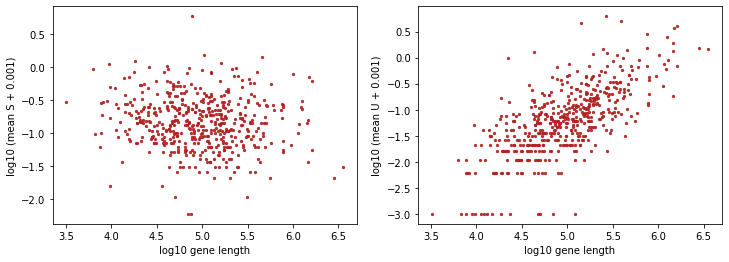

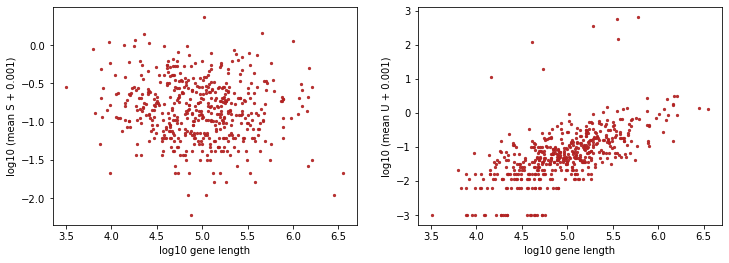

In [262]:
#Control test with standard Monod fit on first, known cluster of cells
result_strings = []
#for i in range(1,2): #n_datasets
for i in range(len(ks)-2,len(ks)):

    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})

    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])

    full_result_string = inference_parameters.fit_all_grid_points(30,search_data)

    result_strings.append(full_result_string)

In [263]:
sr = [monod.analysis.load_search_results(i) for i in result_strings]
sr

INFO:root:Grid scan results loaded from ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_beta90_sim_k10_k1/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230505_025_simTests_edgecase_MM_1/oneClus_all90_sim_k10_k1/Bursty_Poisson_1x1/grid_scan_results.res.


**Check k-means and leiden clusters before running mixture model**

Show k-means inits

In [320]:
len(all_assigns)

2000

In [642]:
all_groups_kmeans = []

INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k1
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k5
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k5/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k10
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_e

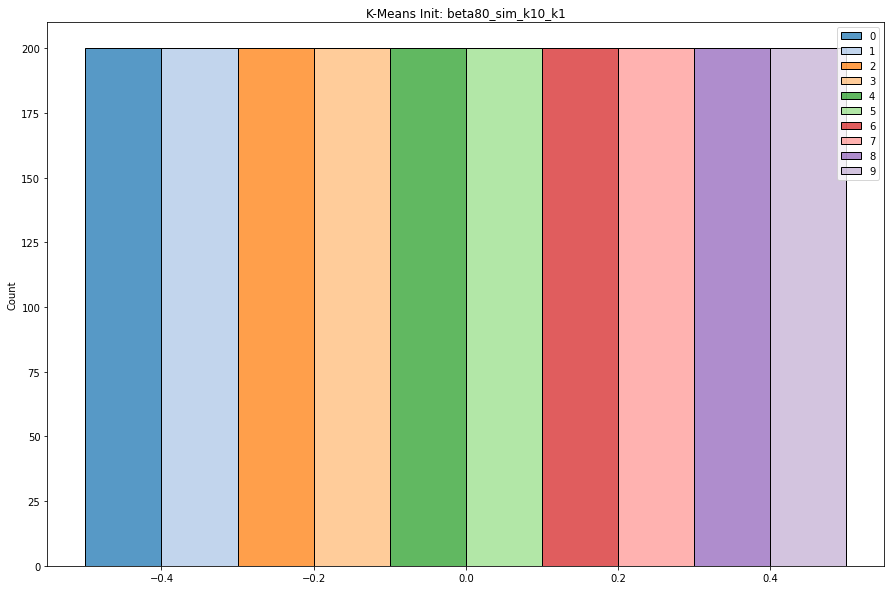

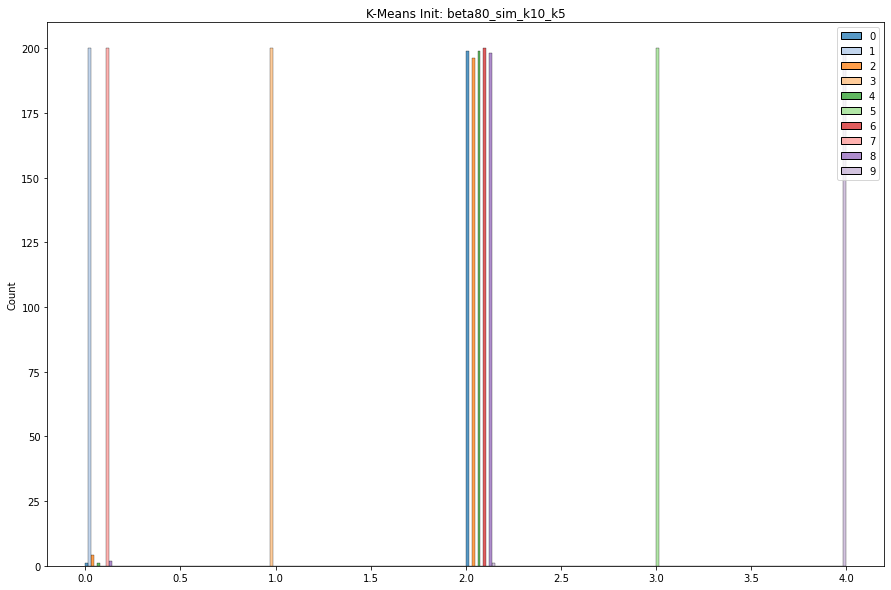

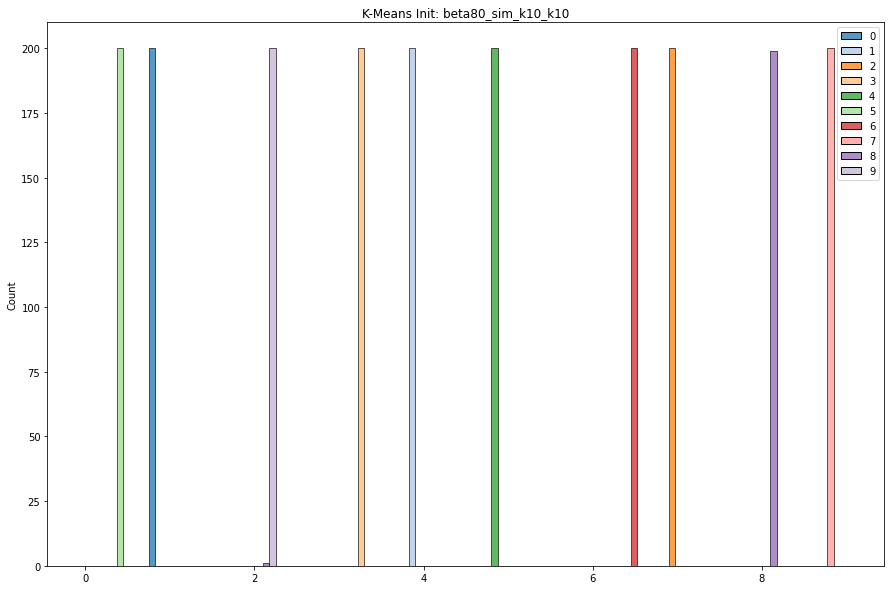

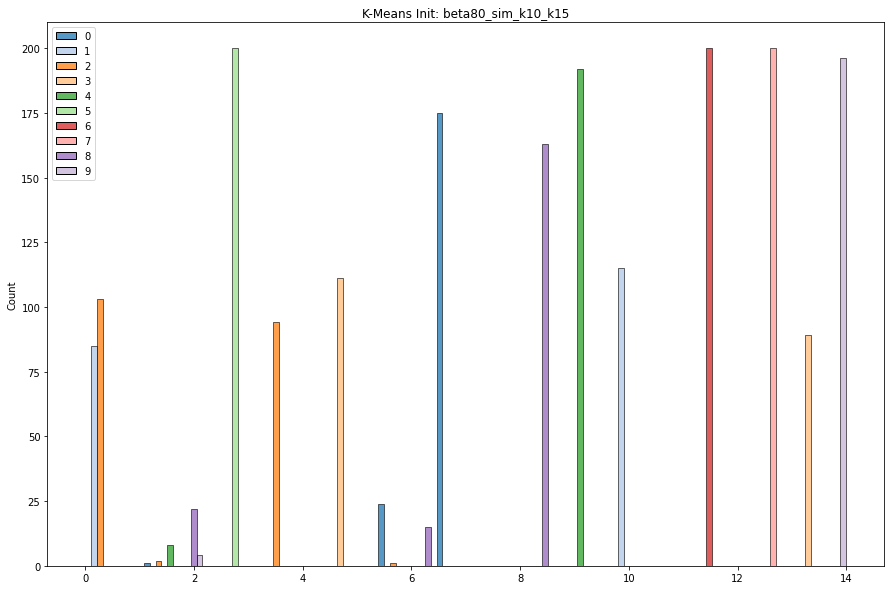

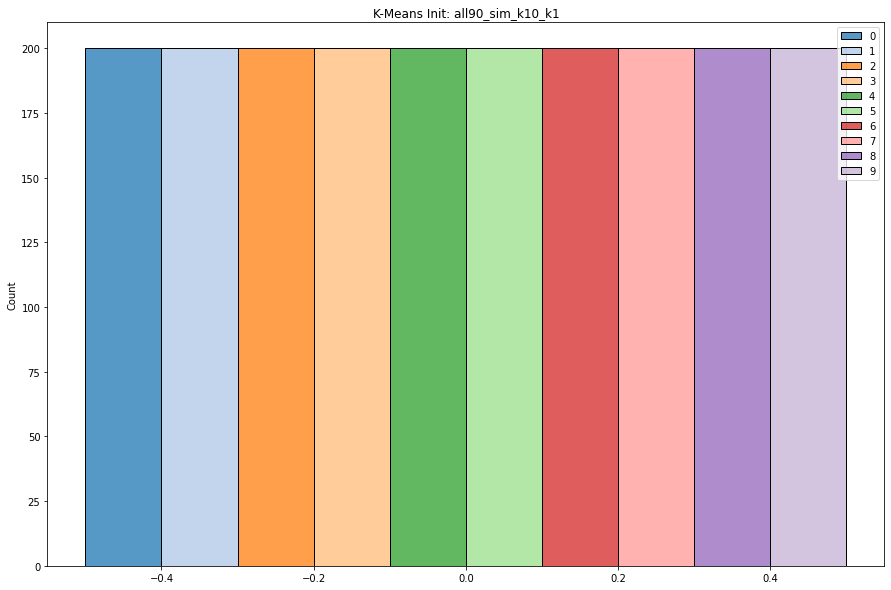

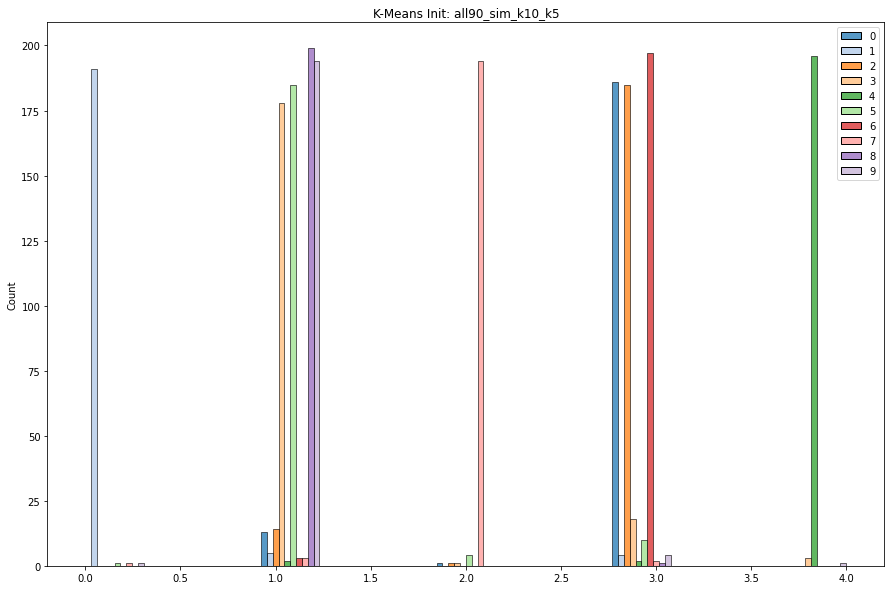

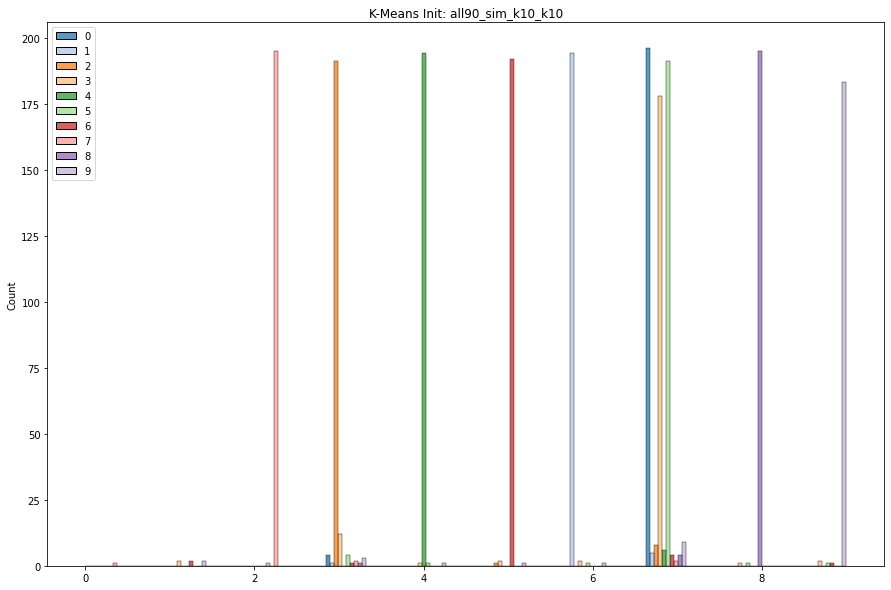

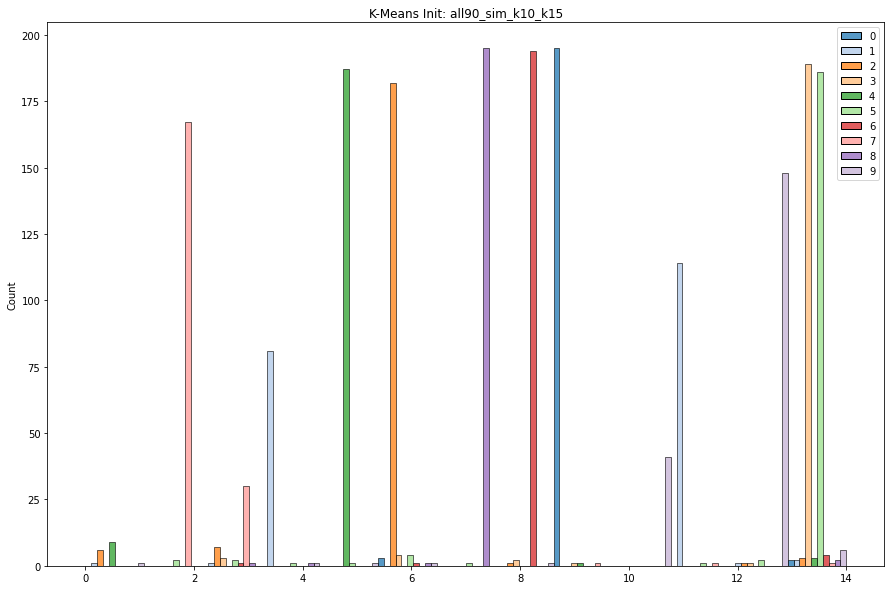

In [643]:
for i in range(len(ks)-2):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    
    S = search_data.layers[1,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)

    kmeans = KMeans(n_clusters=ks[i], random_state=0).fit(S_t)
    labs = kmeans.labels_
    
    all_groups_kmeans += [labs]

    labels = labs
    plt.figure(figsize=(15,10))
    sns.histplot(x=labels,hue=pd.Categorical(all_assigns), kde=False,palette='tab20',multiple="dodge")
    plt.title('K-Means Init: '+dataset_names[i])

    
    

INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k1
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k5
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k5/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k10
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_e

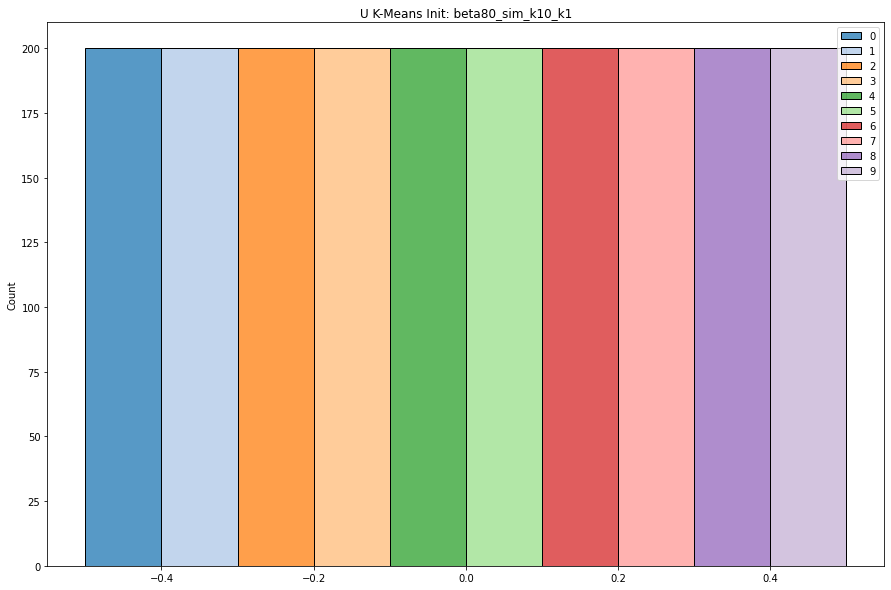

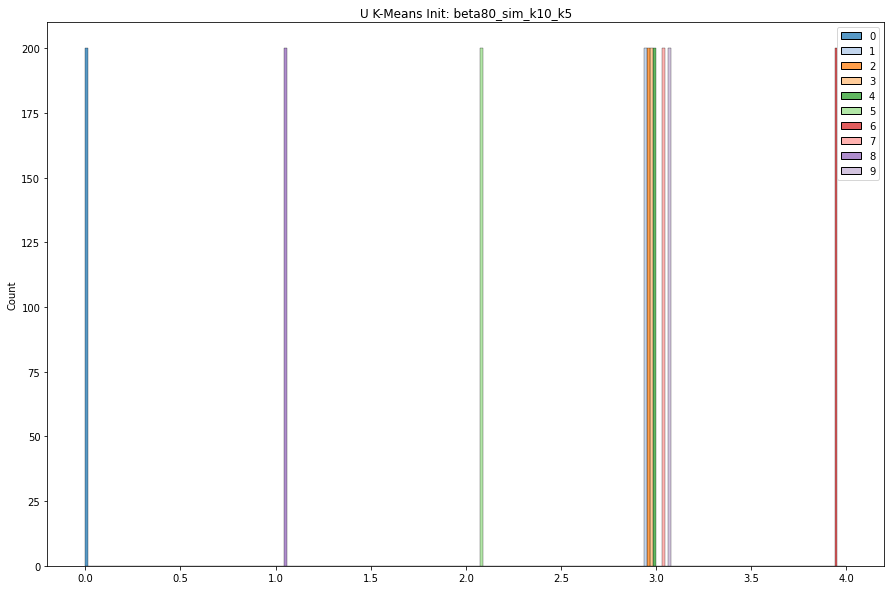

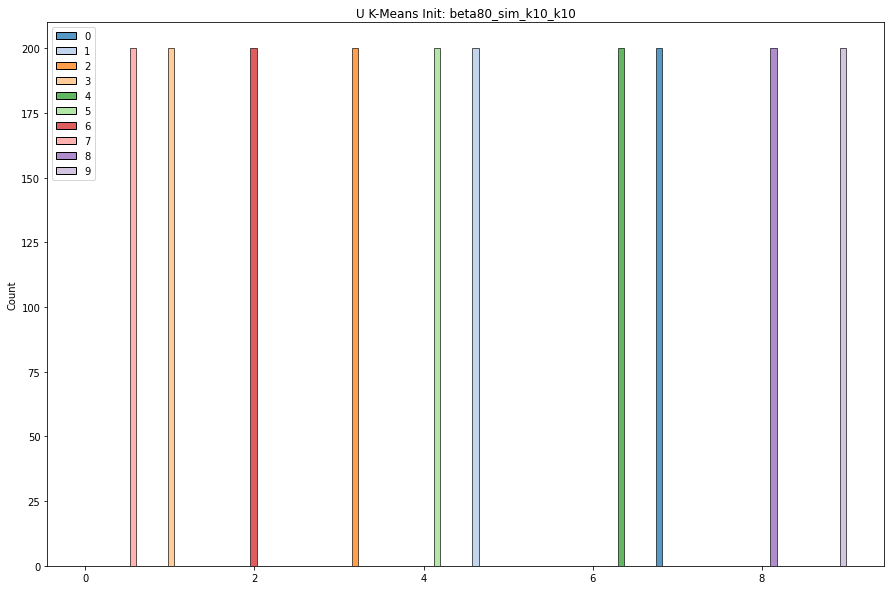

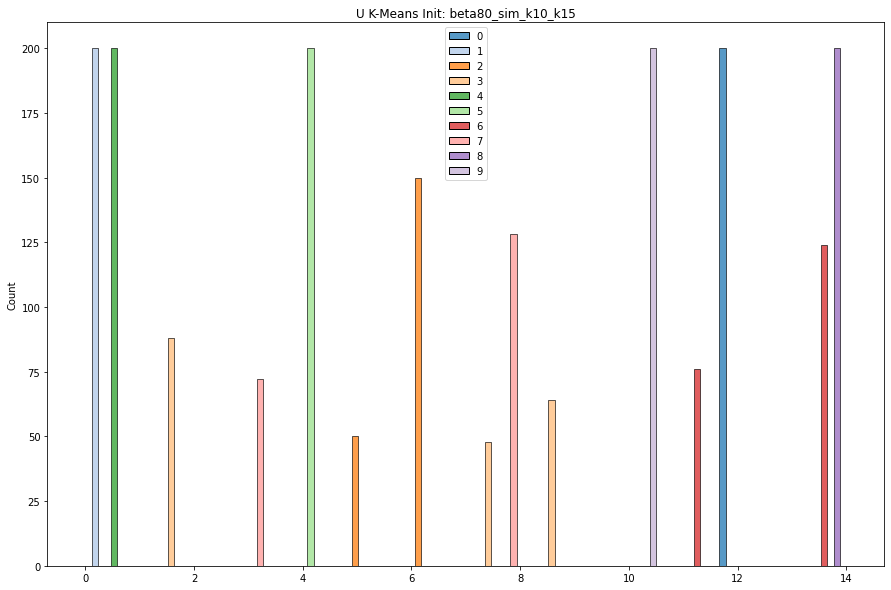

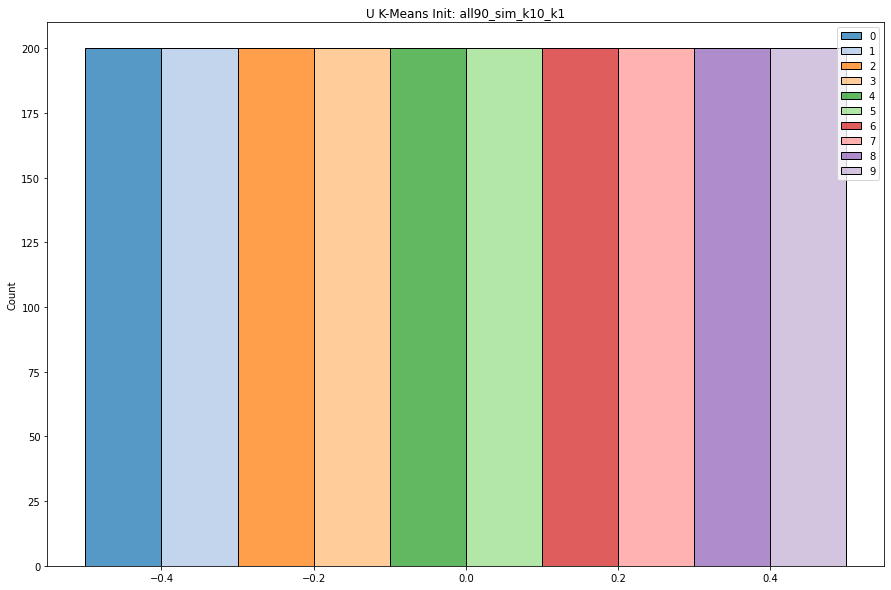

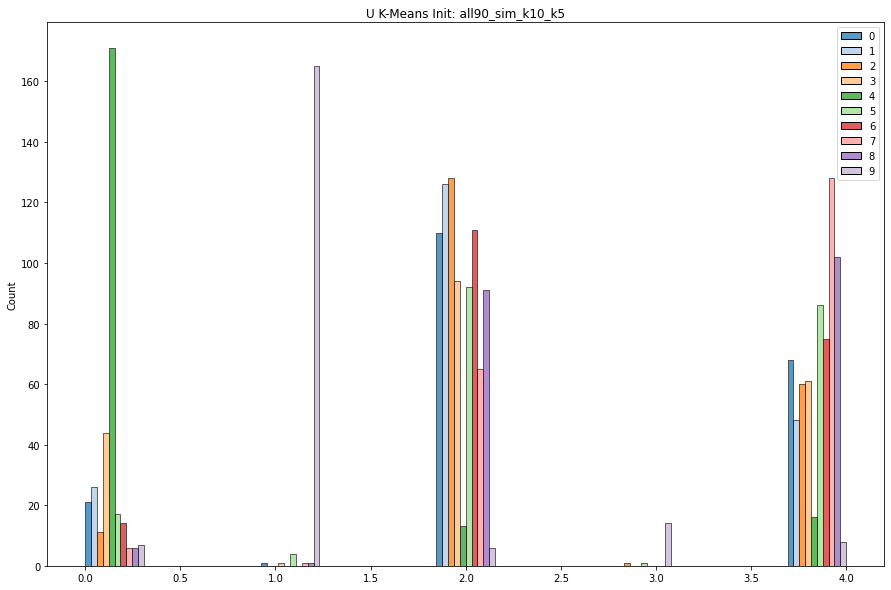

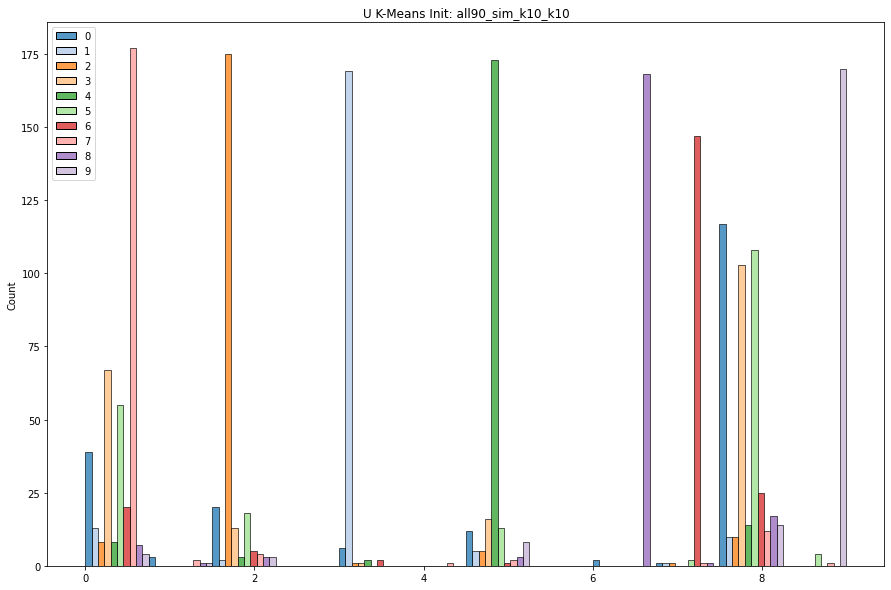

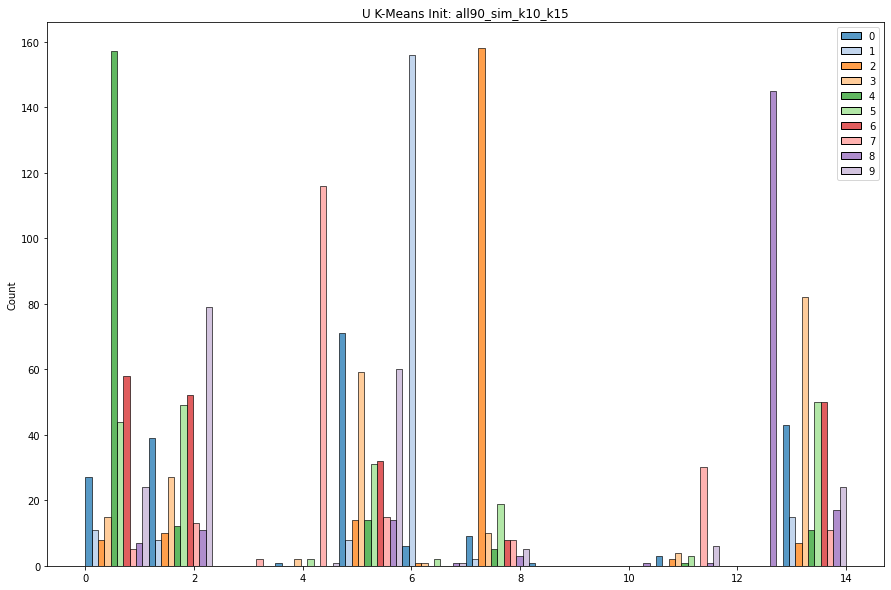

In [644]:
for i in range(len(ks)-2):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    
    S = search_data.layers[0,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)

    kmeans = KMeans(n_clusters=ks[i], random_state=0).fit(S_t)
    labs = kmeans.labels_

    labels = labs
    all_groups_kmeans += [labs]
    
    plt.figure(figsize=(15,10))
    sns.histplot(x=labels,hue=pd.Categorical(all_assigns), kde=False,palette='tab20',multiple="dodge")
    plt.title('U K-Means Init: '+dataset_names[i])

    
    

INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k1
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k5
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k5/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k10
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_e

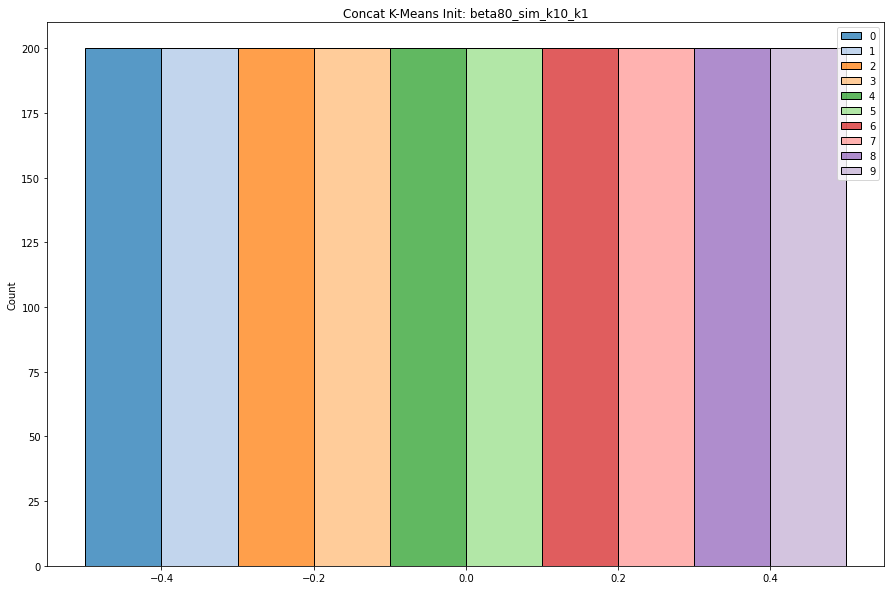

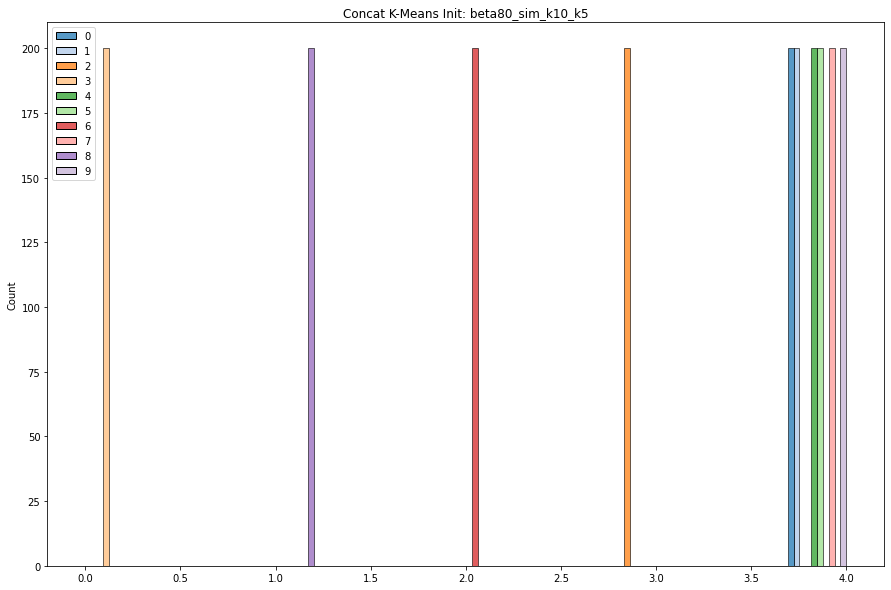

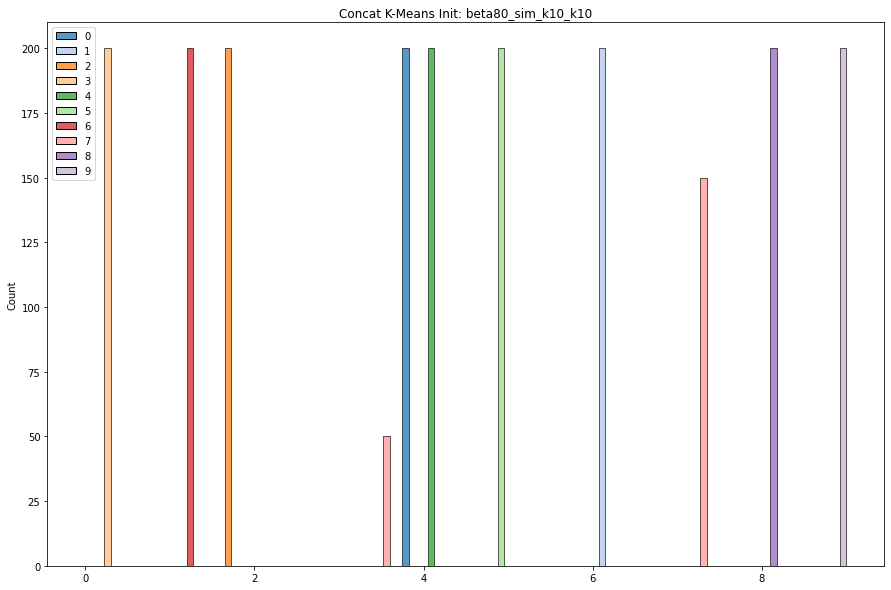

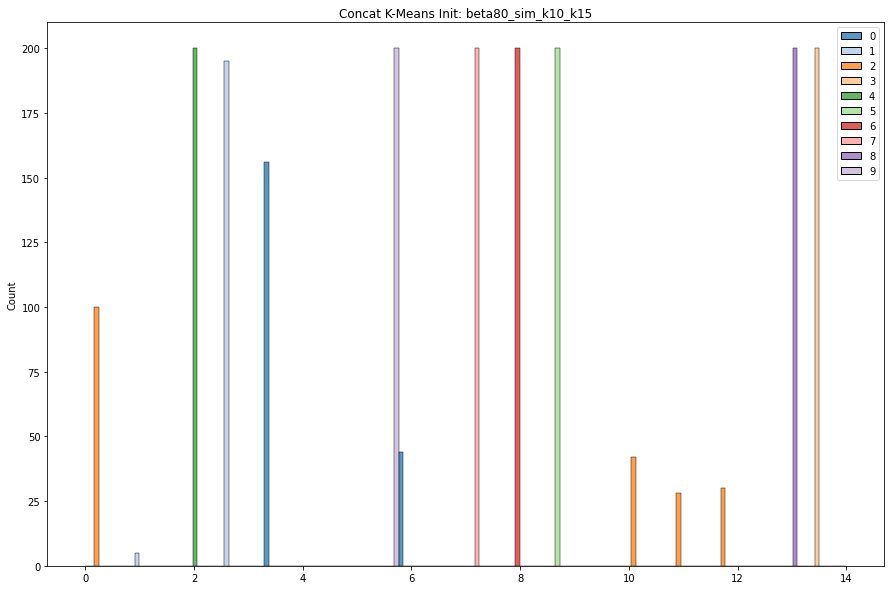

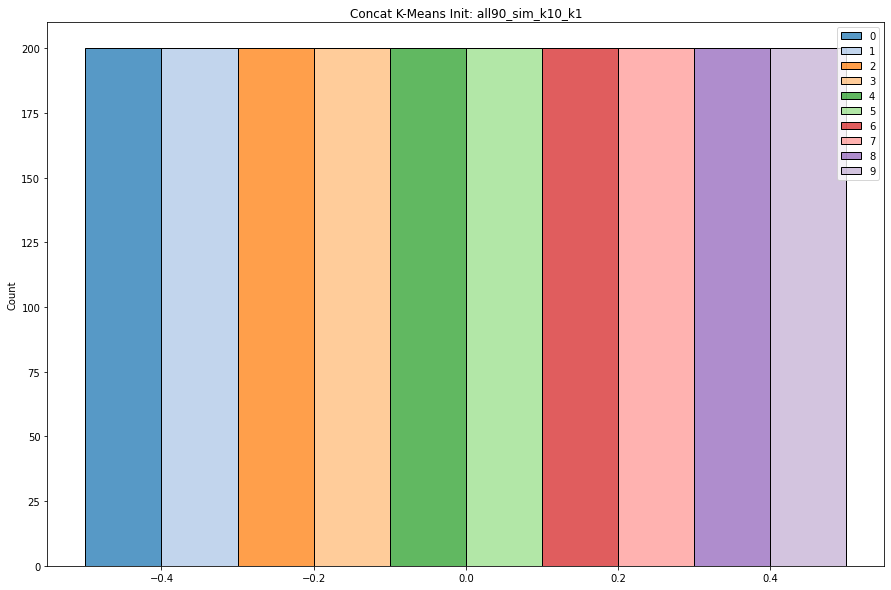

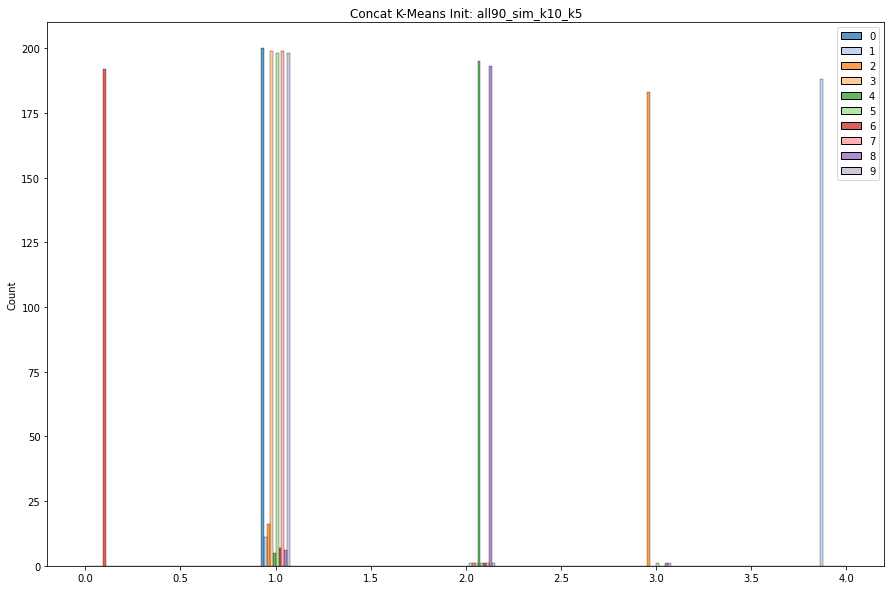

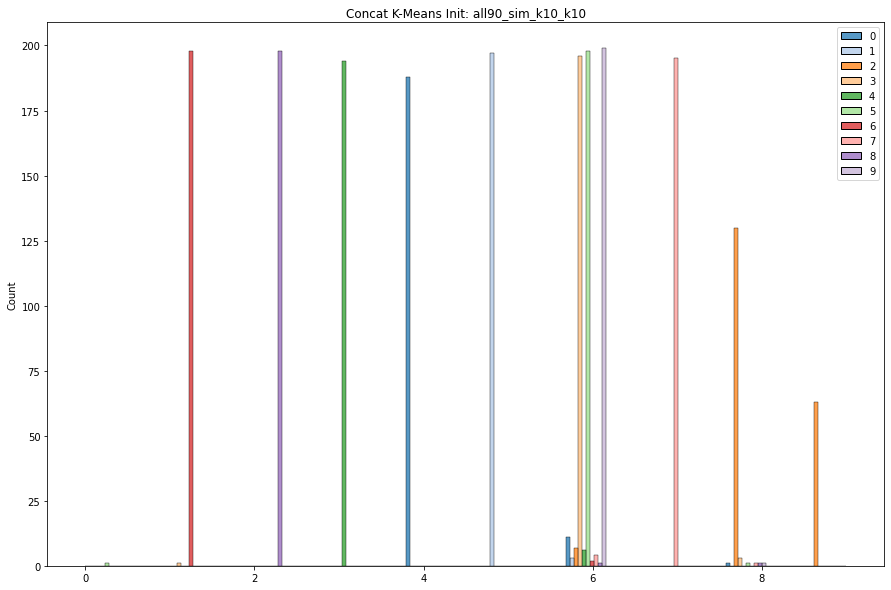

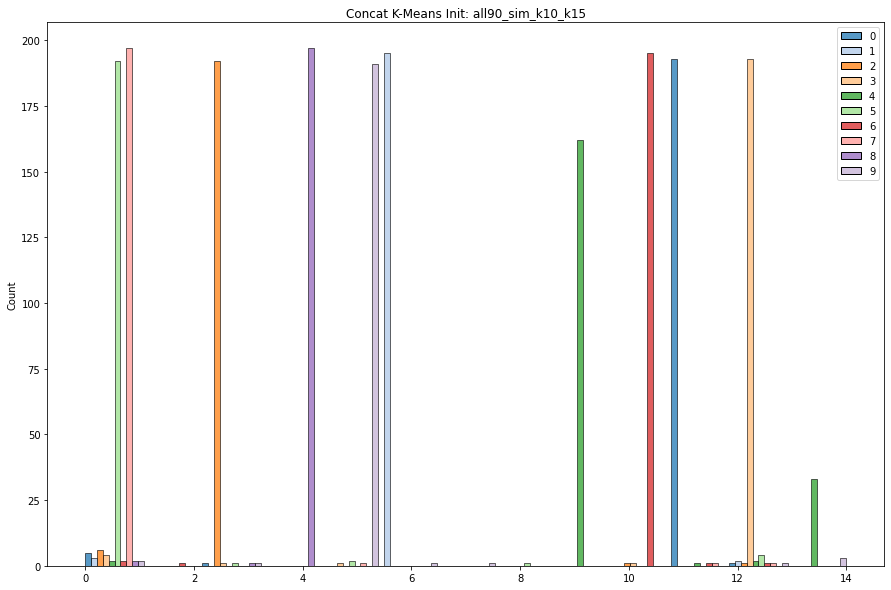

In [645]:
for i in range(len(ks)-2):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    
    U = search_data.layers[0,:,:]
    U_t = U.T
    S = search_data.layers[1,:,:]
    S_t = S.T
    
    concat = np.concatenate((U_t, S_t), axis=1)

    tots = np.sum(concat,axis=1)
    divids = (1e4/tots)[:,None]
    concat = concat*divids
    concat = np.log1p(concat)

    
    
    kmeans = KMeans(n_clusters=ks[i], random_state=0).fit(concat)
    labs = kmeans.labels_

    labels = labs
    all_groups_kmeans += [labs]
    
    plt.figure(figsize=(15,10))
    sns.histplot(x=labels,hue=pd.Categorical(all_assigns), kde=False,palette='tab20',multiple="dodge")
    plt.title('Concat K-Means Init: '+dataset_names[i])

    
    

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


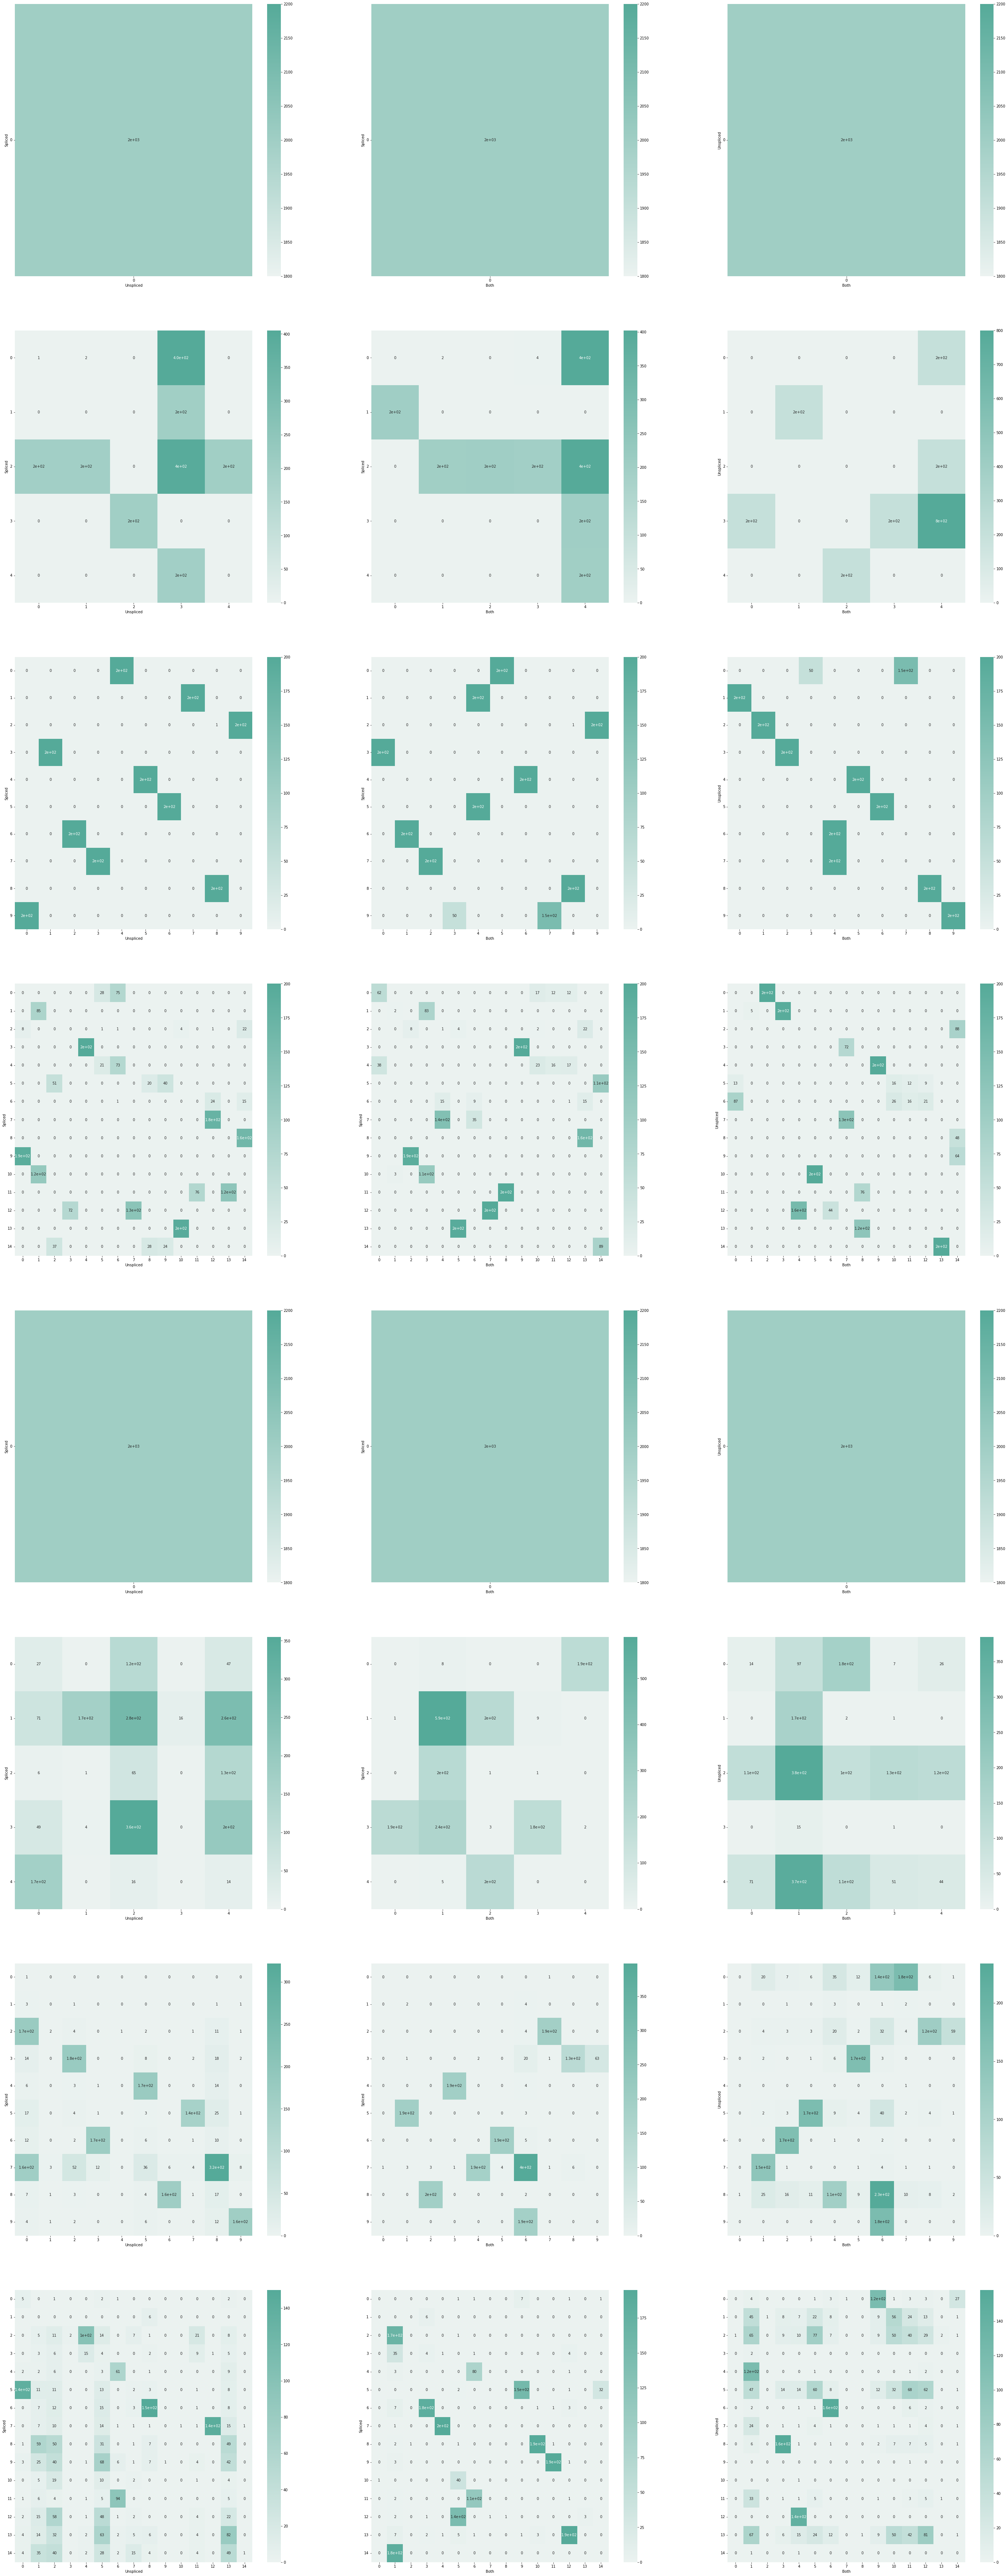

In [646]:
#compare overlap of all k-means assignments

num_per_set = len(ks)-2

pairs = [(0,1),(0,2),(1,2)]
labs = [('Spliced','Unspliced'),('Spliced','Both'),('Unspliced','Both')]
#Plot confmats
fig, ax = plt.subplots(nrows=num_per_set, ncols=len(pairs), figsize=(50,130))
    
for i in range(0,num_per_set):
    
    for j in range(len(pairs)):
        
        p = pairs[j]
        
        assign = all_groups_kmeans[p[1]*(num_per_set)+i]
        true = all_groups_kmeans[p[0]*(num_per_set)+i]

        true_copy = list(true)
        assign_copy = list(assign)

        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    true_copy += [a]
                    assign_copy += [a]


        conmat = confusion_matrix(true_copy, assign_copy)
        val = np.mat(conmat) 
        classnames = list(set(true_copy))
        df_cm = pd.DataFrame(

                val, index=classnames, columns=classnames, 

            )


        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    print(df_cm.shape)
                    df_cm.loc[a,a] = df_cm.loc[a,a]-1


        heatmap = sns.heatmap(df_cm, annot=True, 
                              cmap=sns.color_palette("light:#5A9", as_cmap=True),ax=ax[i,j])
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)

        ax[i,j].set_ylabel(labs[j][0])
        ax[i,j].set_xlabel(labs[j][1])

    
plt.show()
    

Show leiden clusters

In [647]:
neigh = 30
all_groups = []
res = [0.25,0.5,1.0,2.0]*len(out_names)

INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k1
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k5
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k5/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k10
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_e

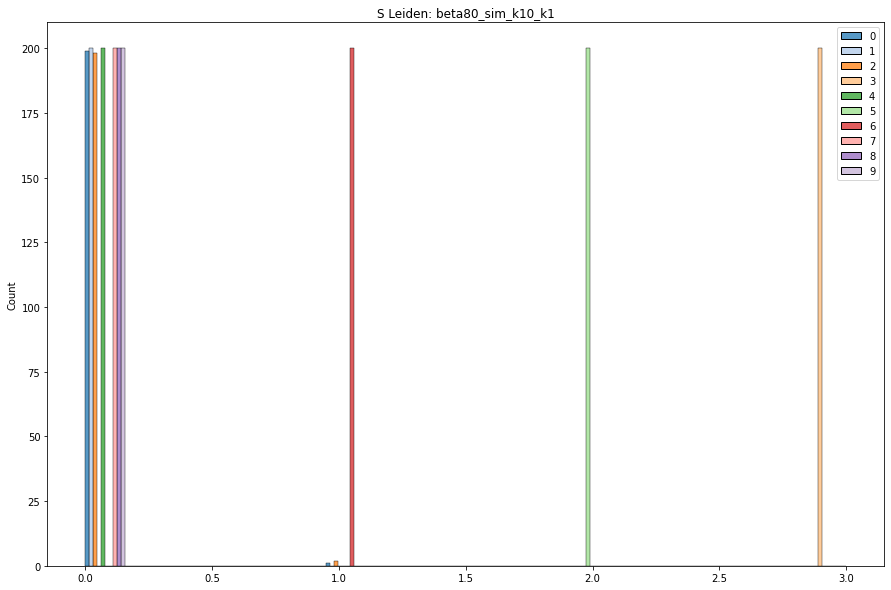

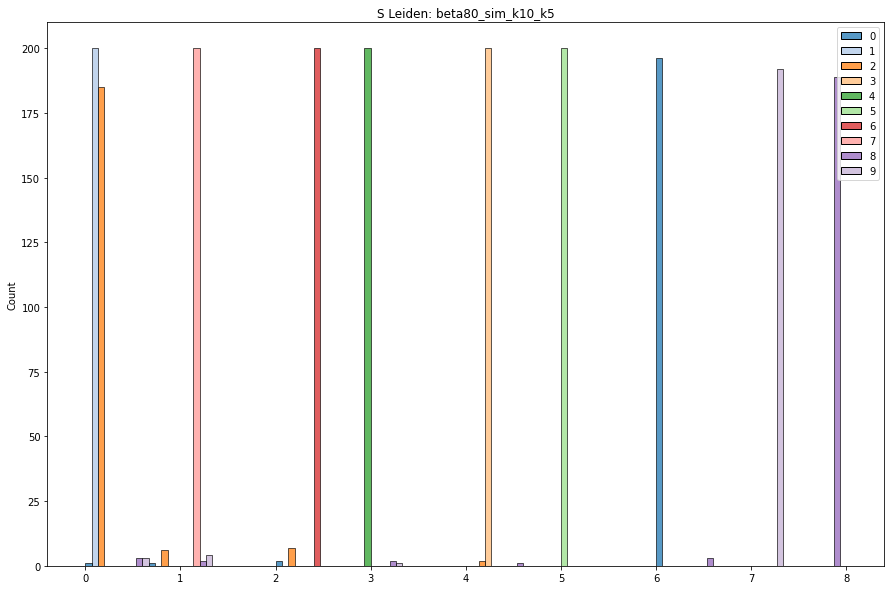

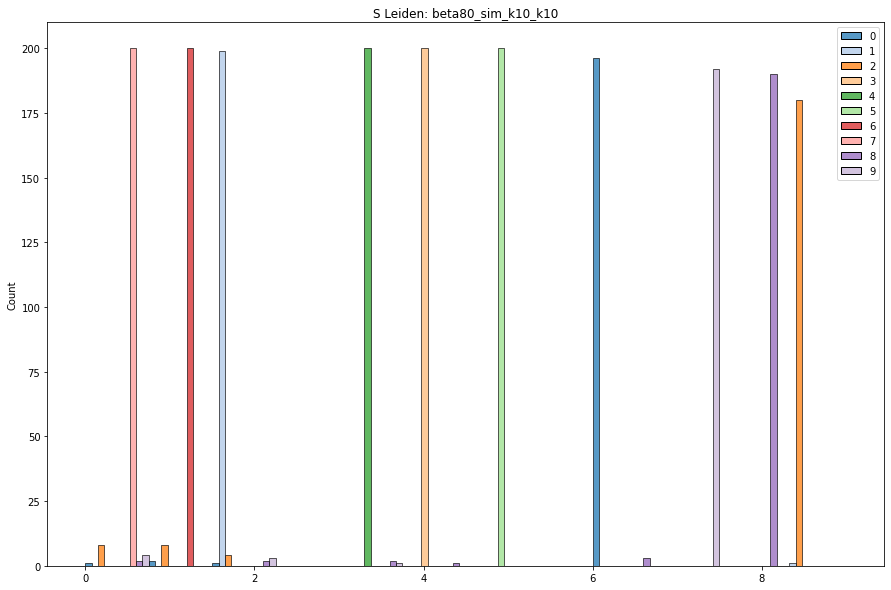

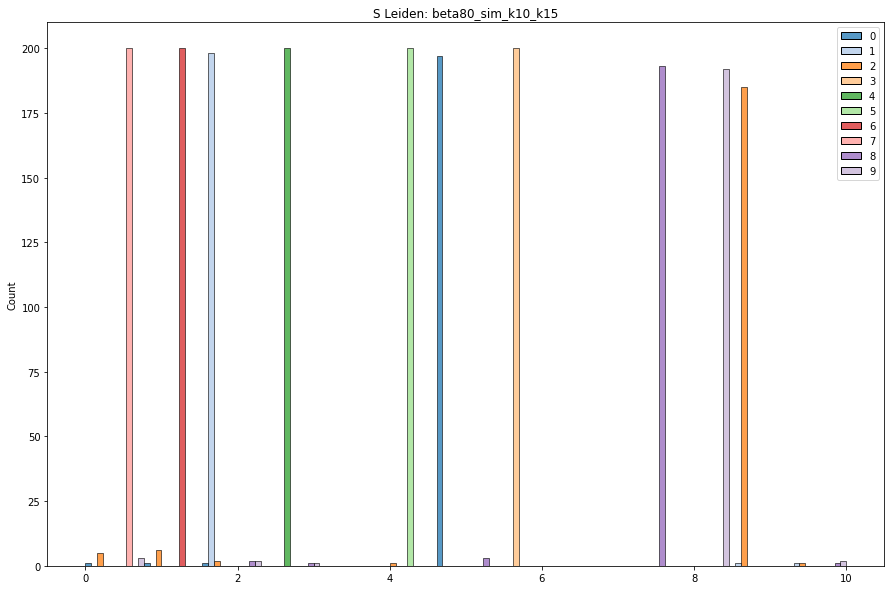

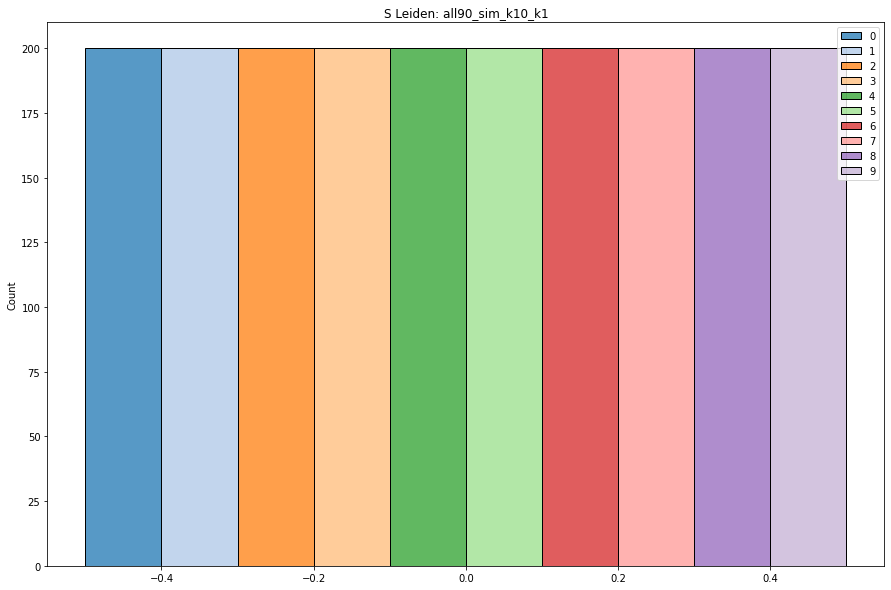

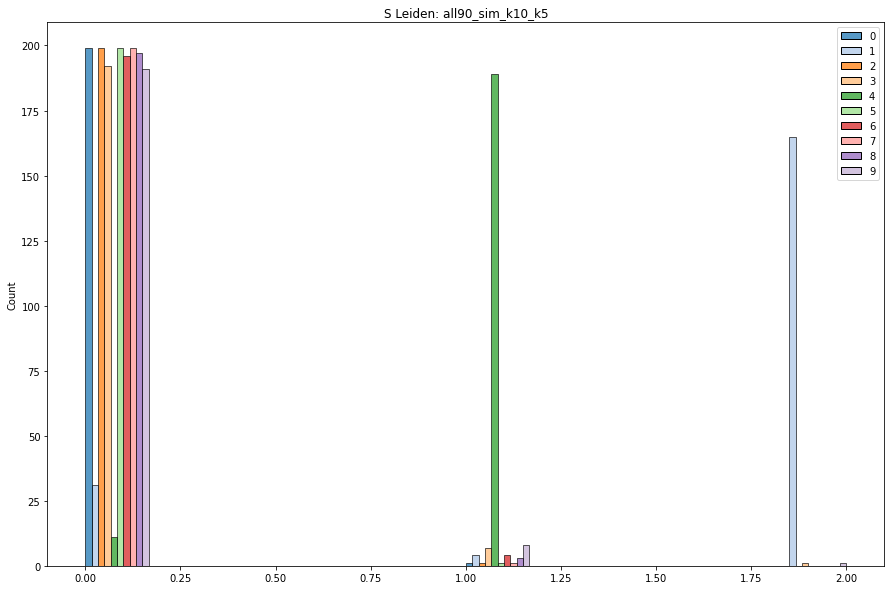

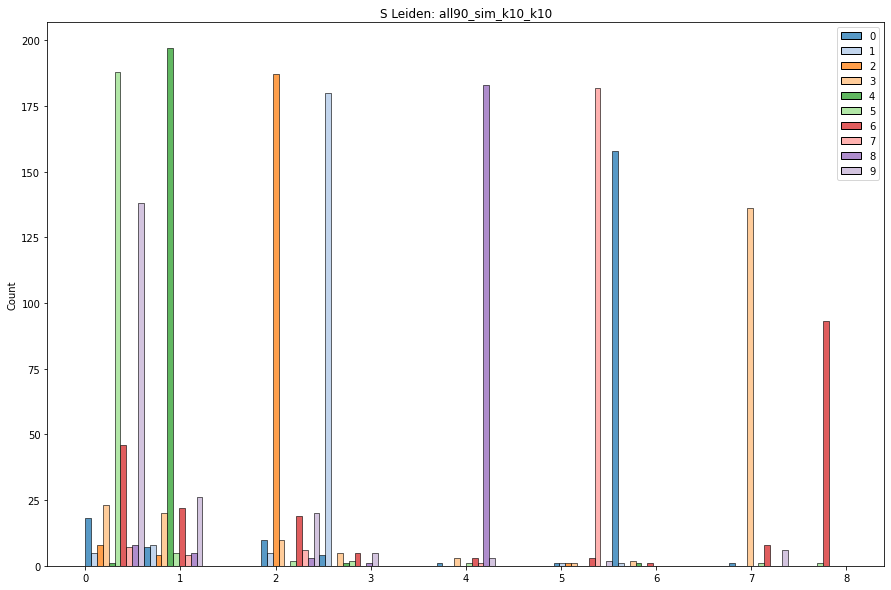

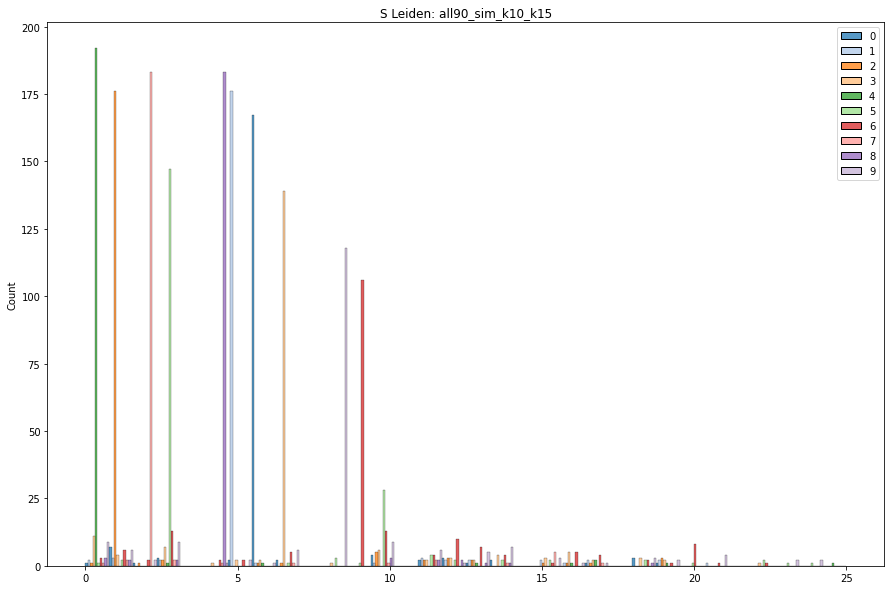

In [648]:
#From https://github.com/scverse/scanpy/blob/ed3b277b2f498e3cab04c9416aaddf97eec8c3e2/scanpy/tools/_leiden.py#L24-L177
for i in range(len(ks)-2):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    #Spliced
    S = search_data.layers[1,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)

    A = kneighbors_graph(S_t, neigh, mode='connectivity', include_self=True)
    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=False) #True in scanpy, which is odd
    g.add_vertices(A.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))

    g.es['weight'] = weights
    
    partition_type = la.RBConfigurationVertexPartition
    
    
    part = la.find_partition(g, partition_type, 
                                    weights=np.array(g.es['weight']).astype(np.float64), 
                                    n_iterations=-1, resolution_parameter=res[i])

    all_groups += [np.array(part.membership)]
    
    labels = np.array(part.membership)
    plt.figure(figsize=(15,10))
    sns.histplot(x=labels,hue=pd.Categorical(all_assigns), kde=False,palette='tab20',multiple="dodge")
    plt.title('S Leiden: '+dataset_names[i])
    
    
    


INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k1
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k5
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k5/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k10
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_e

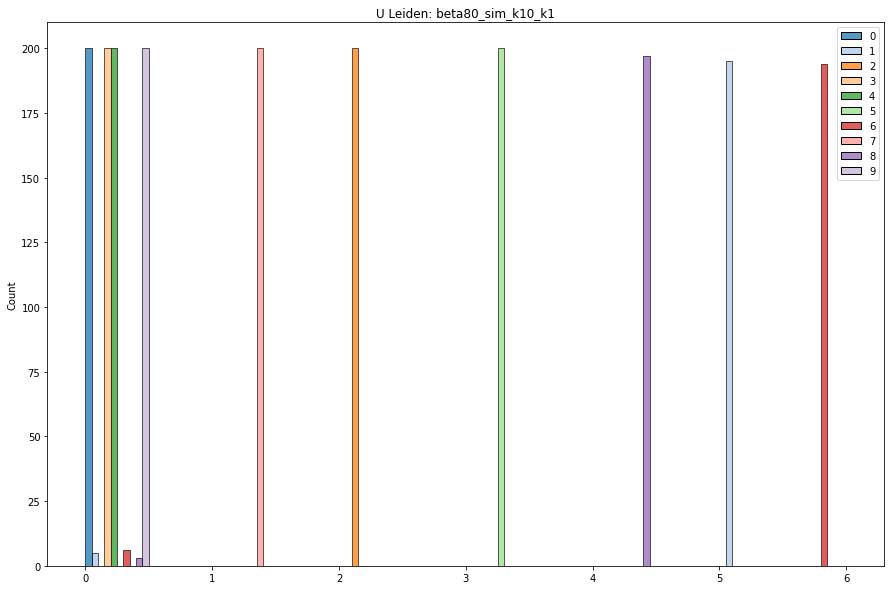

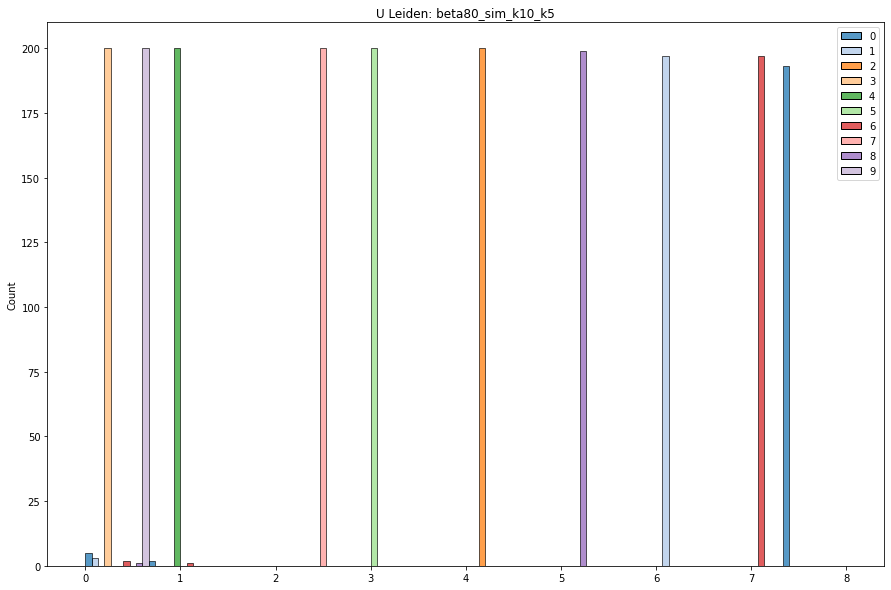

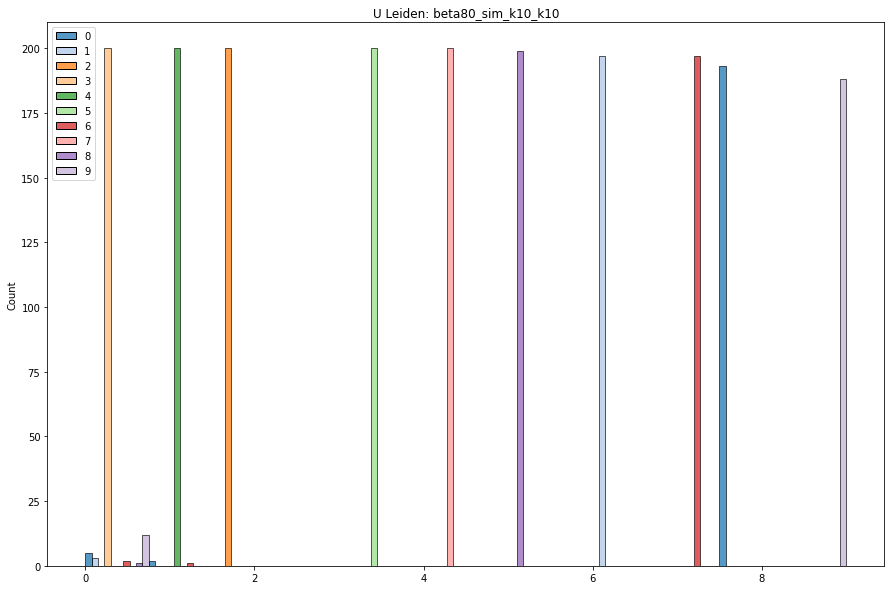

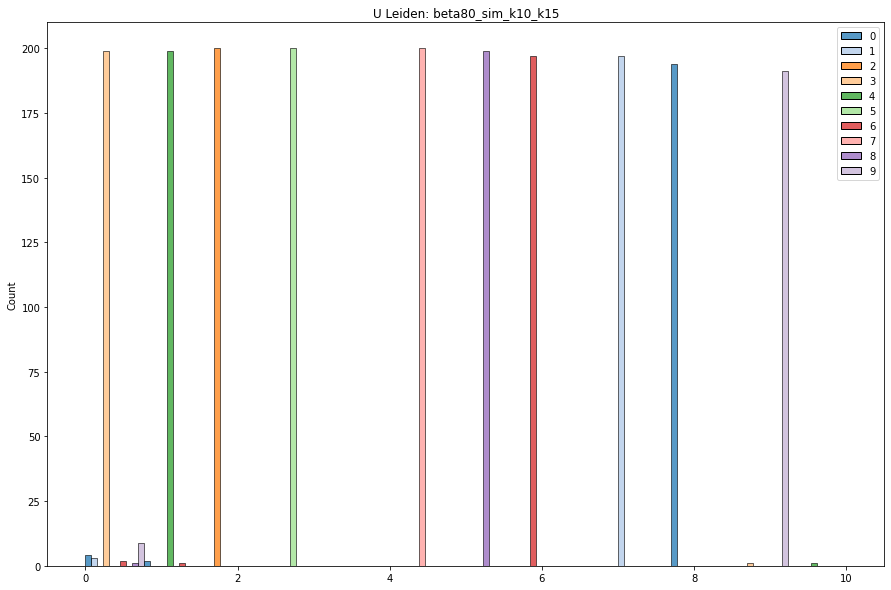

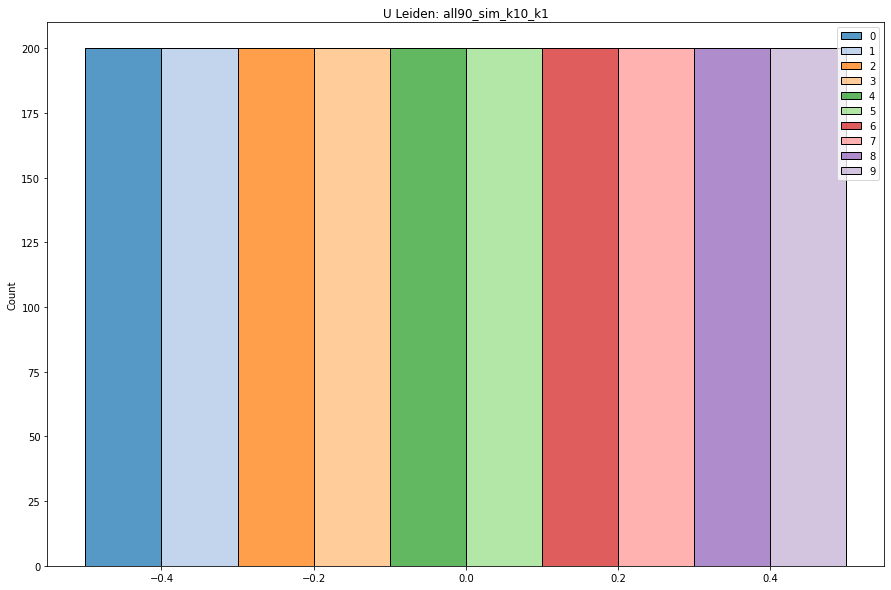

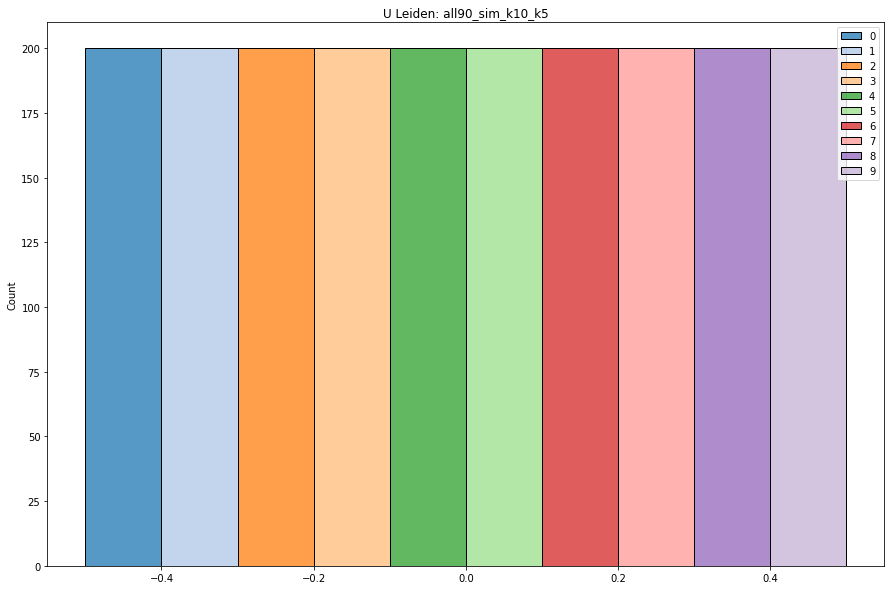

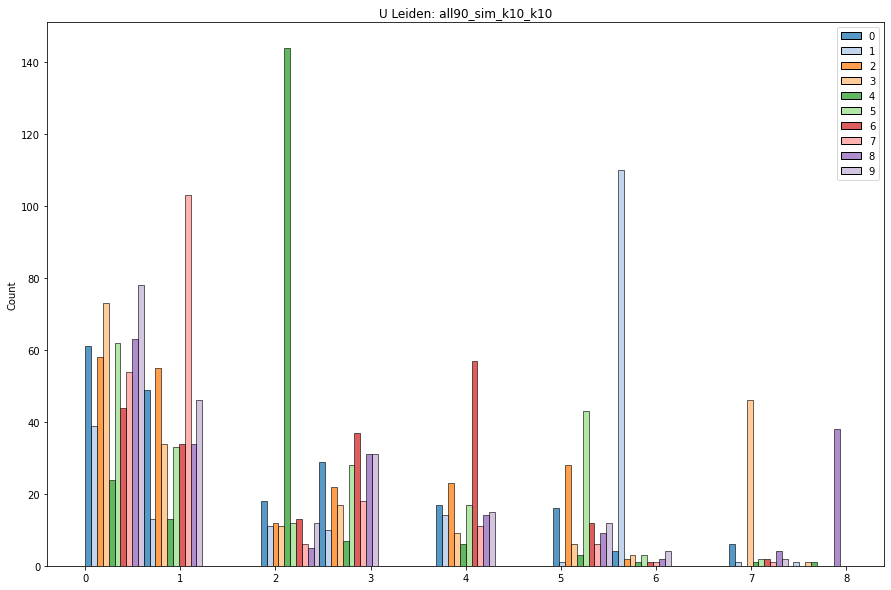

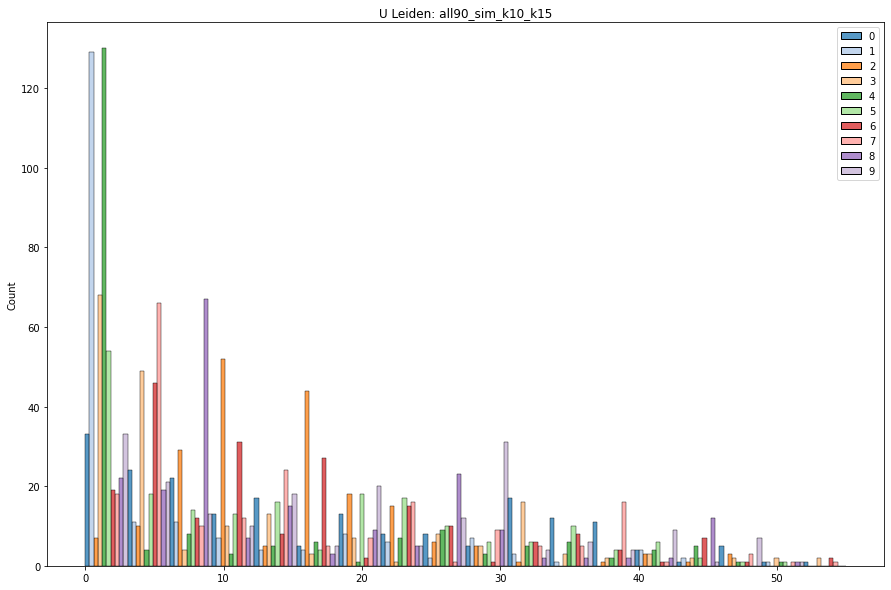

In [649]:
for i in range(len(ks)-2):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    #Unspliced
    S = search_data.layers[0,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)

    A = kneighbors_graph(S_t, neigh, mode='connectivity', include_self=True)
    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=False) #True in scanpy, which is odd
    g.add_vertices(A.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))

    g.es['weight'] = weights
    
    partition_type = la.RBConfigurationVertexPartition
    
    
    part = la.find_partition(g, partition_type, 
                                    weights=np.array(g.es['weight']).astype(np.float64), 
                                    n_iterations=-1, resolution_parameter=res[i])

    all_groups += [np.array(part.membership)]
    
    labels = np.array(part.membership)
    plt.figure(figsize=(15,10))
    sns.histplot(x=labels,hue=pd.Categorical(all_assigns), kde=False,palette='tab20',multiple="dodge")
    plt.title('U Leiden: '+dataset_names[i])
    

INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k1
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k5
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/beta80_sim_k10_k5/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta80_sim_k10_k10
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_e

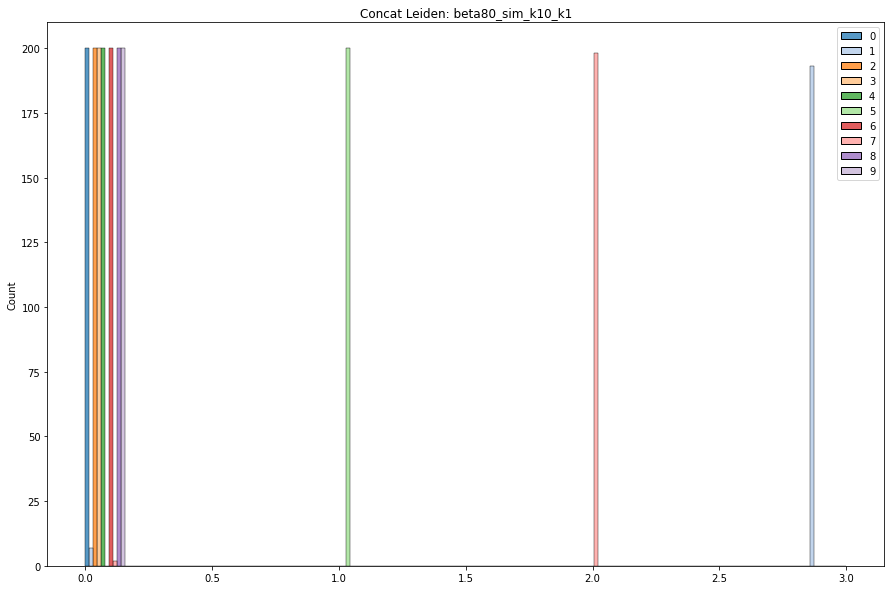

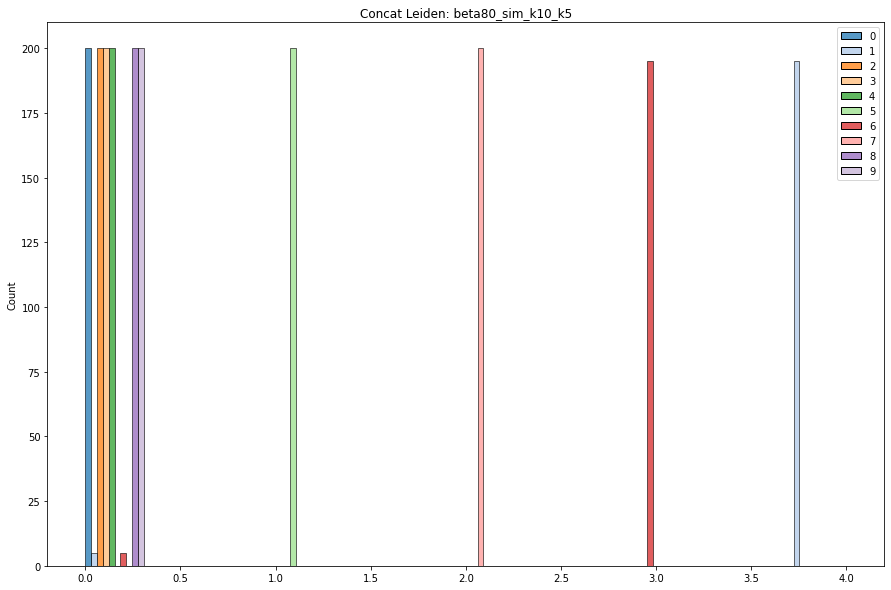

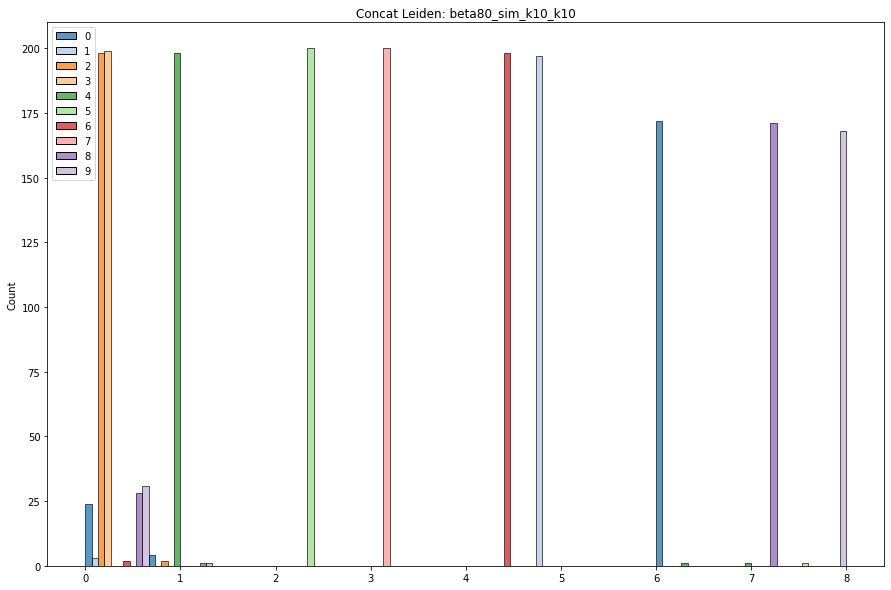

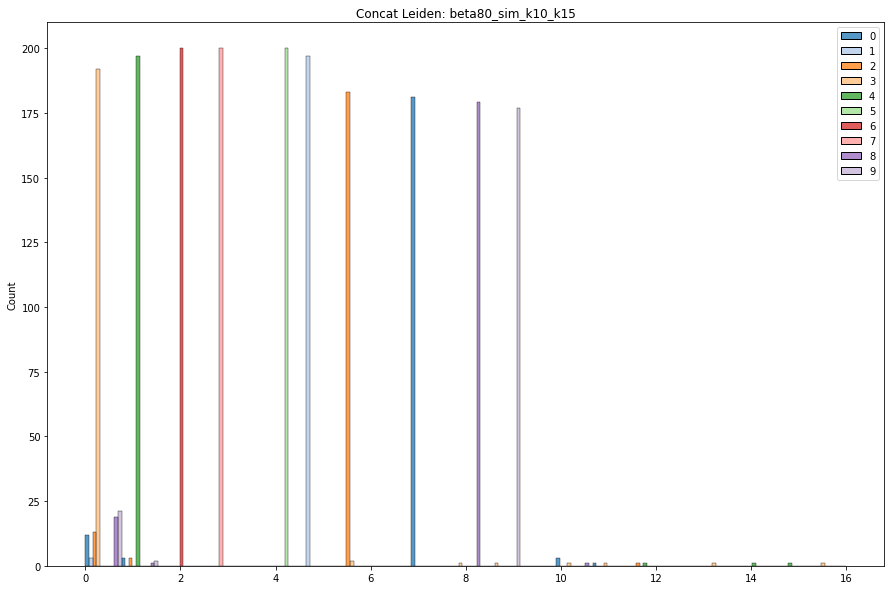

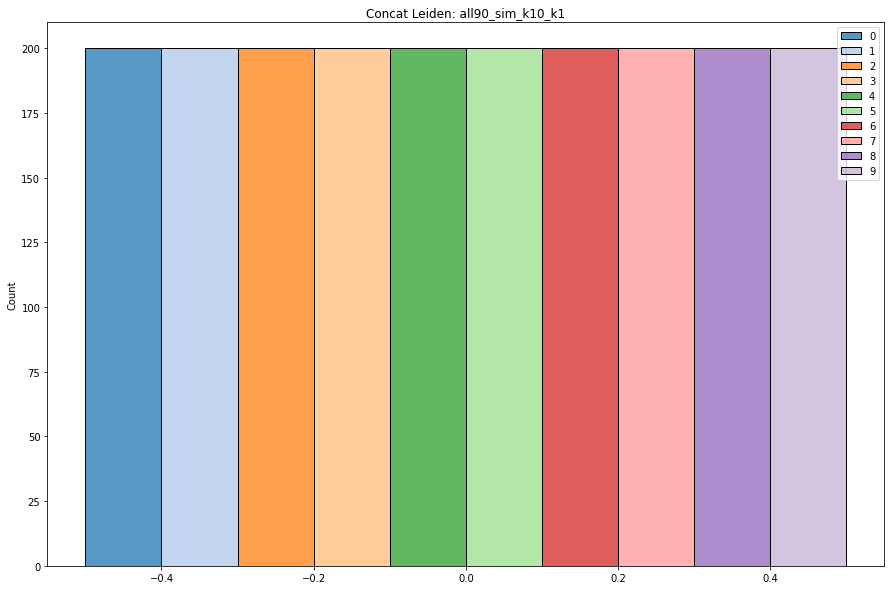

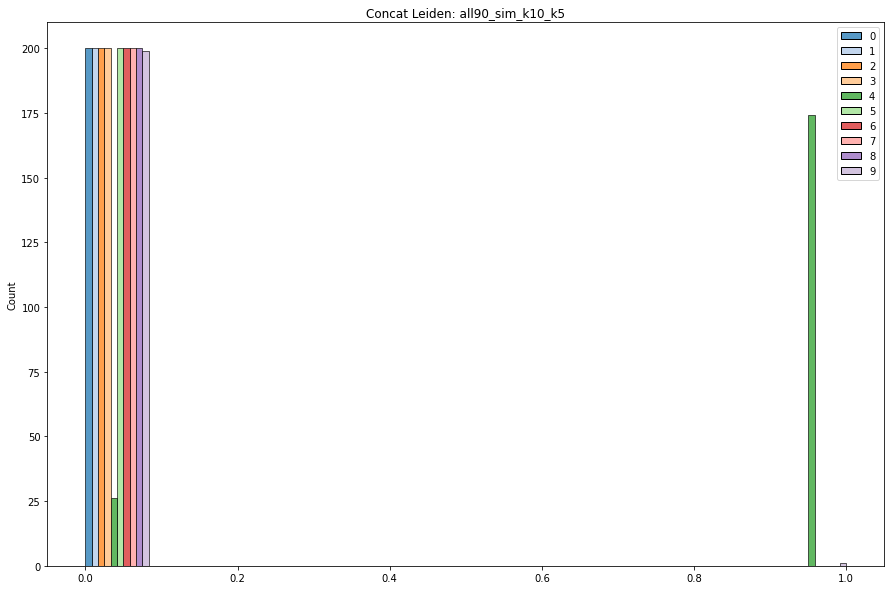

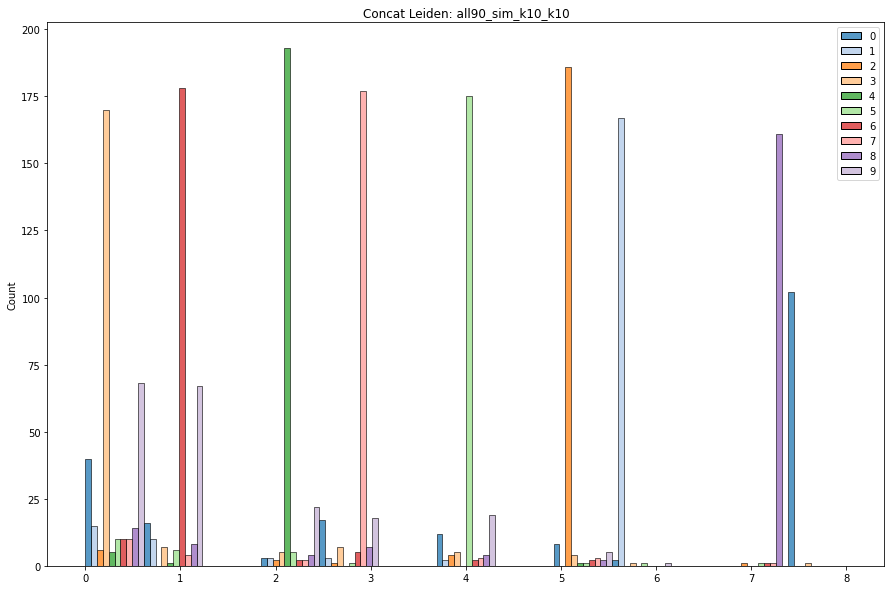

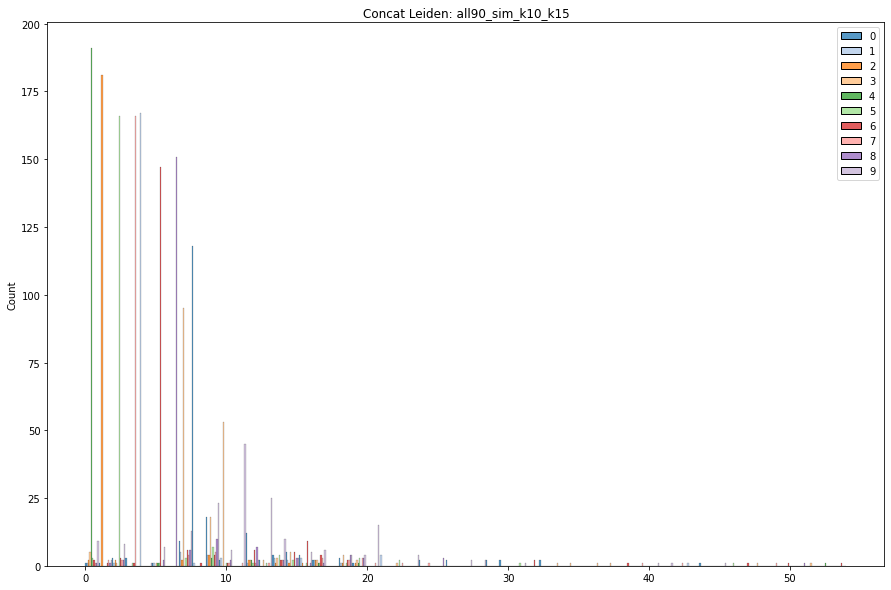

In [650]:
for i in range(len(ks)-2):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    
    U = search_data.layers[0,:,:]
    U_t = U.T
    S = search_data.layers[1,:,:]
    S_t = S.T
    
    concat = np.concatenate((U_t, S_t), axis=1)

    tots = np.sum(concat,axis=1)
    divids = (1e4/tots)[:,None]
    concat = concat*divids
    concat = np.log1p(concat)
    
    A = kneighbors_graph(concat, neigh, mode='connectivity', include_self=True)
    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=False) #True in scanpy, which is odd
    g.add_vertices(A.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))

    g.es['weight'] = weights
    
    partition_type = la.RBConfigurationVertexPartition
    
    
    part = la.find_partition(g, partition_type, 
                                    weights=np.array(g.es['weight']).astype(np.float64), 
                                    n_iterations=-1, resolution_parameter=res[i])

    all_groups += [np.array(part.membership)]
    
    labels = np.array(part.membership)
    plt.figure(figsize=(15,10))
    sns.histplot(x=labels,hue=pd.Categorical(all_assigns), kde=False,palette='tab20',multiple="dodge")
    plt.title('Concat Leiden: '+dataset_names[i])
    
    
    

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(7, 7)
(7, 7)
(7, 7)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(17, 17)
(17, 17)
(17, 17)
(17, 17)
(17, 17)
(17, 17)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(17, 17)
(17, 17)
(17, 17)
(17, 17)
(17, 17)
(17, 17)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(2, 2)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


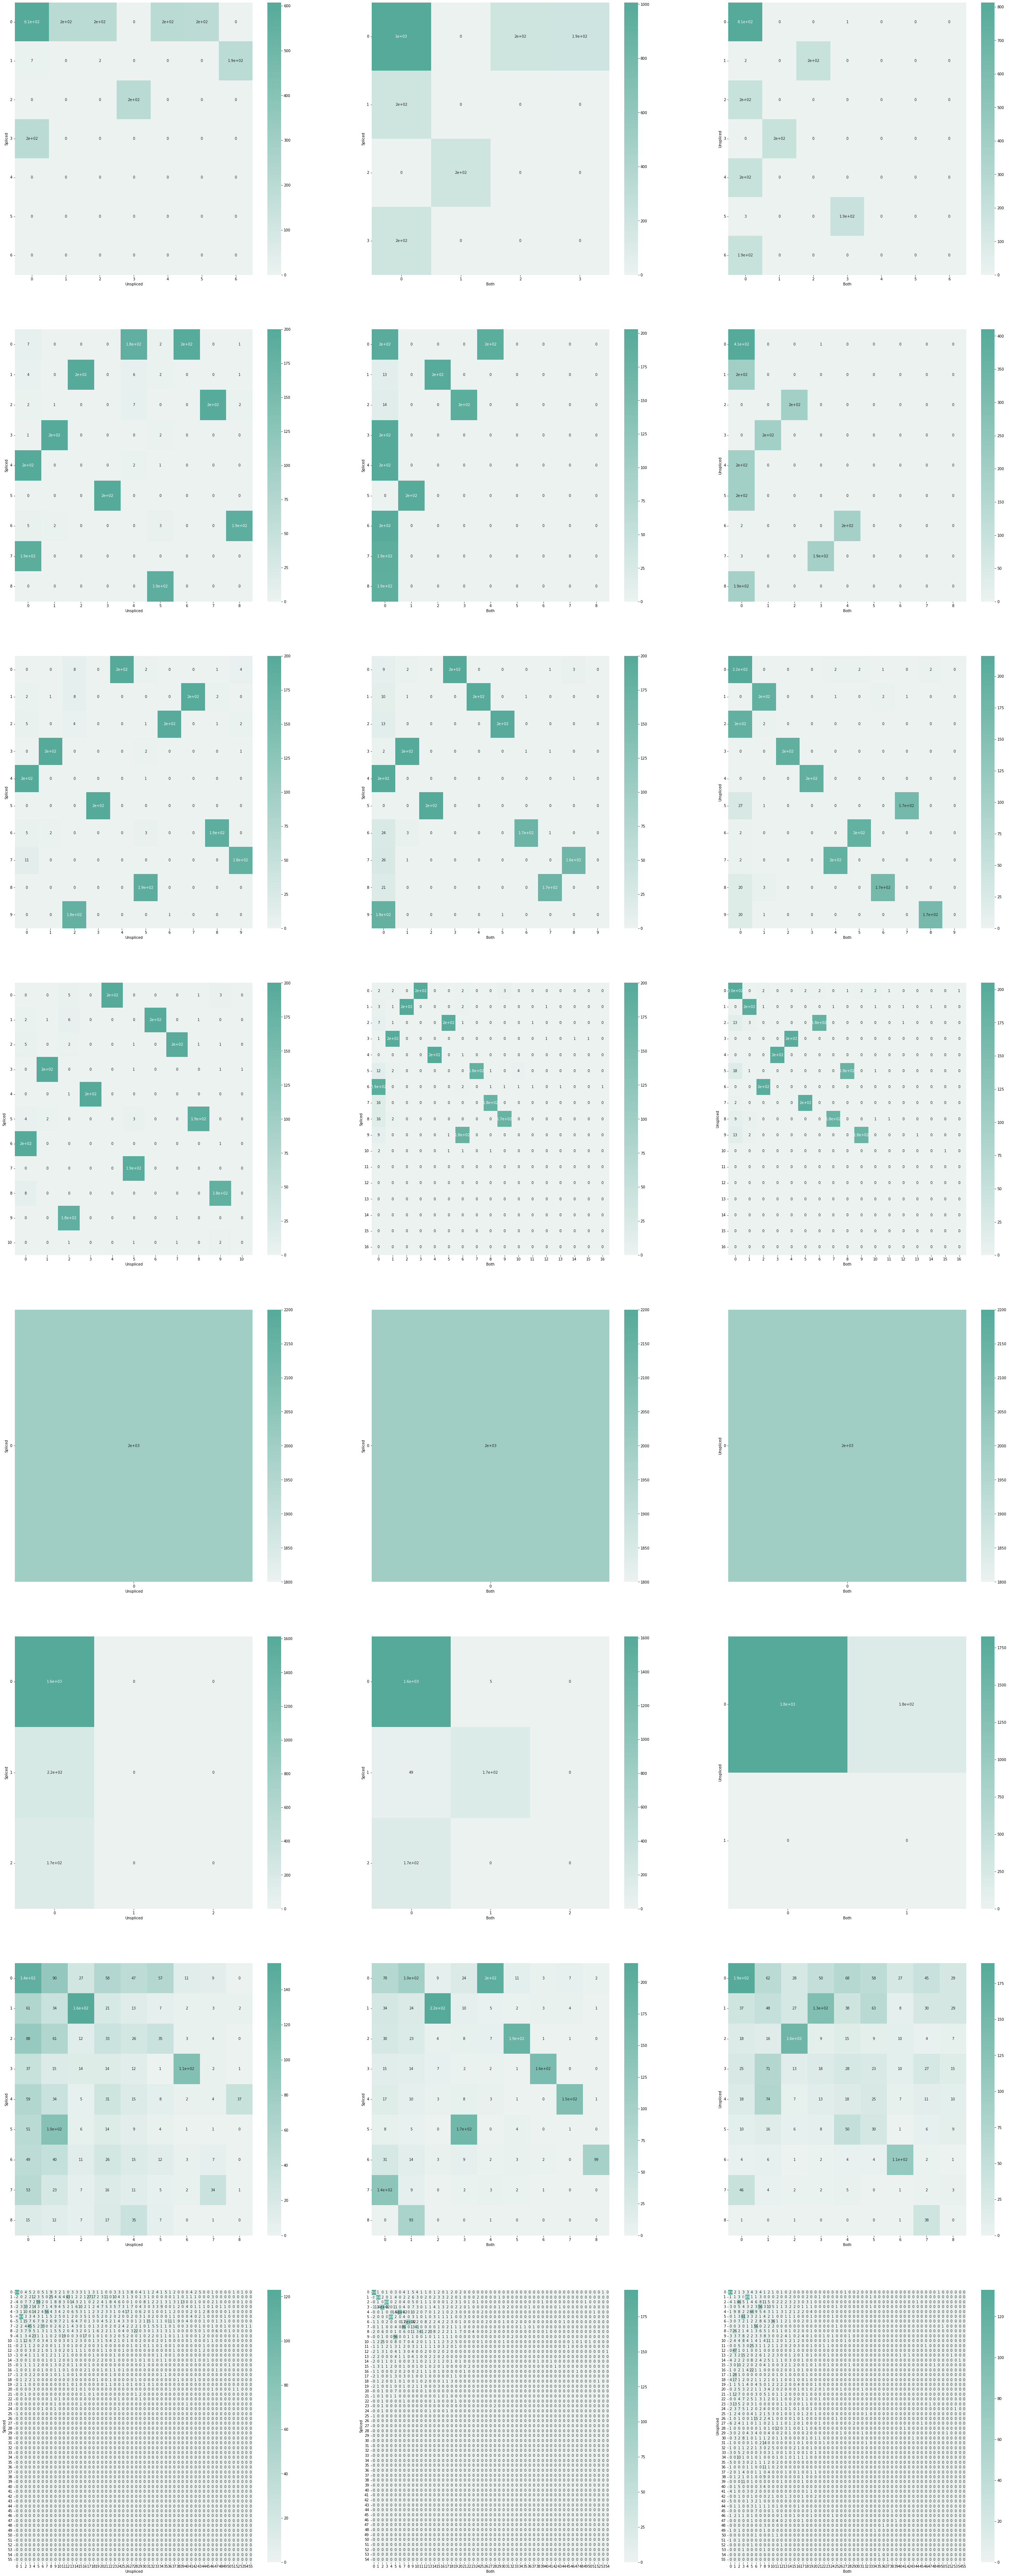

In [651]:
#compare overlap of all leiden assignments

num_per_set = len(ks)-2

pairs = [(0,1),(0,2),(1,2)]
labs = [('Spliced','Unspliced'),('Spliced','Both'),('Unspliced','Both')]
#Plot confmats
fig, ax = plt.subplots(nrows=num_per_set, ncols=len(pairs), figsize=(50,130))
    
for i in range(0,num_per_set):
    
    for j in range(len(pairs)):
        
        p = pairs[j]
        
        assign = all_groups[p[1]*(num_per_set)+i]
        true = all_groups[p[0]*(num_per_set)+i]

        true_copy = list(true)
        assign_copy = list(assign)

        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    true_copy += [a]
                    assign_copy += [a]


        conmat = confusion_matrix(true_copy, assign_copy)
        val = np.mat(conmat) 
        classnames = list(set(true_copy))
        df_cm = pd.DataFrame(

                val, index=classnames, columns=classnames, 

            )


        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    print(df_cm.shape)
                    df_cm.loc[a,a] = df_cm.loc[a,a]-1


        heatmap = sns.heatmap(df_cm, annot=True, 
                              cmap=sns.color_palette("light:#5A9", as_cmap=True),ax=ax[i,j])
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)

        ax[i,j].set_ylabel(labs[j][0])
        ax[i,j].set_xlabel(labs[j][1])

    
plt.show()
    

**RUN MIXTURE MODEL**


In [488]:
epochs=20

In [601]:
dataset_names

['beta80_sim_k10_k1',
 'beta80_sim_k10_k5',
 'beta80_sim_k10_k10',
 'beta80_sim_k10_k15',
 'all90_sim_k10_k1',
 'all90_sim_k10_k5',
 'all90_sim_k10_k10',
 'all90_sim_k10_k15',
 'oneClus_beta80_sim_k10_k1',
 'oneClus_all90_sim_k10_k1']

In [ ]:
result_strings = []
for i in [7]: #range(len(ks)-2): #n_datasets, running data with all clusters,(len(ks)-3),3,-1, RAN 2
    
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,k=ks[i],epochs=epochs,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})
    
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[i])
    
    inference_parameters.fit_all_grid_points(50,search_data)


INFO:root:Directory ./fits/gg_230505_025_simTests_edgecase_MM_1/all90_sim_k10_k15/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/all90_sim_k10_k15/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: all90_sim_k10_k15
INFO:root:500 features observed, 500 match genome annotations. 500 were unique.
INFO:root:Gene list extracted from ./fits/gg_230505_025_simTests_edgecase_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230505_025_simTests_edgecase_MM_1/all90_sim_k10_k15/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


  0%|                                                                                                                               | 0/15 [00:00<?, ?it/s]

In [ ]:
#beta80_sim_k10_k10 ok 

## **Analysis of Results**

In [492]:
#Plot cluster concordance with true labels and distribution of clusters 
def vis_assign(true,assign,title='',figsize=(18, 5)):
    true_copy = list(true)
    assign_copy = list(assign)
    if np.max(assign) > np.max(true): #FIX
        for a in np.unique(assign):
            if a > np.max(true):
                true_copy += [a]
                assign_copy += [a]
    true_copy = np.array(true_copy)
    assign_copy = np.array(assign_copy)
    
    conmat = confusion_matrix(true_copy, assign_copy)
    val = np.mat(conmat) 
    classnames = list(set(true_copy))
    df_cm = pd.DataFrame(

            val, index=classnames, columns=classnames, 

        )
    
    if np.max(assign) > np.max(true): #FIX
        for a in np.unique(assign):
            if a > np.max(true):
                print(df_cm.shape)
                df_cm.loc[a,a] = df_cm.loc[a,a]-1

    #Plot assignment distributions
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    sns.histplot(x=assign,hue=true, kde=False,ax=ax[0],palette='Pastel1',multiple="dodge")
    ax[0].set_xlabel('MM Assignment')
    ax[0].set_title(title)
    
    #Plot confustion matrix
    heatmap = sns.heatmap(df_cm, annot=True, cmap=sns.color_palette("light:#5A9", as_cmap=True),ax=ax[1])
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
    ax[1].set_ylabel('Original label')
    ax[1].set_xlabel('Assigned label')
    
    
    plt.show()

    

In [493]:
#Plot  aics and loss over time for each k iteration

def vis_metrics(results,title,ks,figsize=(18, 5),s=50):
    num_ks = len(results)
    sets = []
    nlls = []
    res = pd.DataFrame()
    aics = pd.DataFrame()
    klds = pd.DataFrame()
    
    aic = []
    fin_k = []
    kls = []
    
    epoch = len(results[0].all_qs)
    epos = list(range(1,epoch+1))*num_ks
    
    for i in range(num_ks):
        
        nlls += list(-1*np.array(results[i].all_qs))
        sets += [ks[i]]*epoch
        aic += [results[i].aic] #-2*n_cells*clus
        fin_k += [len(np.unique(results[i].assigns))]
        #kls += [np.mean([np.mean(results[i].klds[:,k]) for k in np.unique(results[i].assigns)])]
        
        kls += list(np.mean(np.sum(np.array(results[i].all_klds)[:,:,list(np.unique(results[i].assigns))],axis=1),axis=1))
        
        
    
    
    
    res['NLL'] = nlls
    res['KLD'] = kls
    res['epoch'] = epos
    res['setting'] = ['k='+str(j) for j in sets]
    
    aics['AIC'] = aic
    aics['k'] = [str(j) for j in ks ]
    aics['fin_k'] = fin_k
    

    
    
    #Plot klds over time
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    sns.lineplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('NLL')
    ax[0].set_title(title)
    
    
    #Plot klds
    sns.lineplot(data=res,x='epoch',y='KLD',hue='setting', 
                    ax=ax[1],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='KLD',hue='setting', 
                    ax=ax[1],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('KLD')

    
    
    #Plot aics
    sns.scatterplot(data=aics,x='fin_k',y='AIC',hue='k', ax=ax[2],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[2].set_xlabel('Final k')
    ax[2].set_ylabel('-AIC')
    ax[2].legend(
          title='k')
    
    
 
    plt.show()
    
    
    


In [494]:
#Mixture Model results
import pickle 
results = [i+'/Bursty_Poisson_1x1/grid_point_0.gp' for i in [dataset_strings[2]]]
grid_point_results = []
for r in results:
    with open(r, "rb") as ipfs:
        grid_point_results += [pickle.load(ipfs)]

    

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


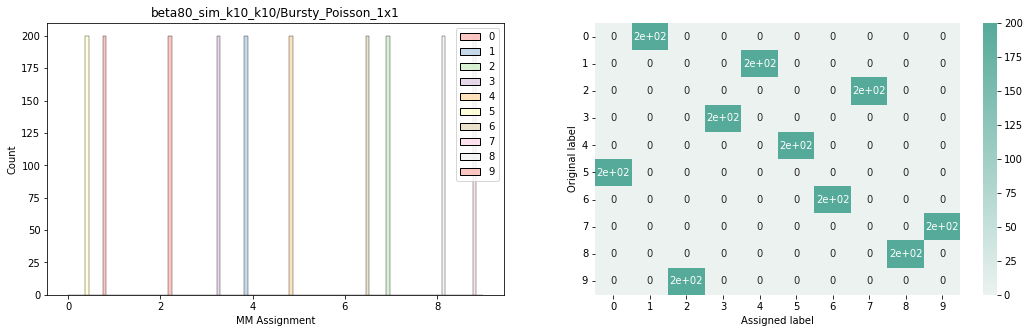

In [495]:
for r in grid_point_results:
    title = r.inference_string.replace('./fits/gg_230505_025_simTests_edgecase_MM_1/','') #./fits/gg_230411_025_simTests_MM_1/
    vis_assign(np.array(all_assigns),r.assigns,title)


In [342]:
for i in range(0, len(grid_point_results), 4):
    r = grid_point_results[i:i+4]
    title = dataset_meta[i]+' Metrics'
    vis_metrics(r,title,ks[i:i+4])

ValueError: Length of values (4) does not match length of index (1)